# Кластеризация К-Средних - K-Means Clustering


Рассмотрим кластеризацию данных - это пример обучения без учителя (unsupervised learning).

## Цель:

Работая с методами обучения без учителя (unsupervised learning), очень важно уделить время на постановку задачи. В нашем примере мы постараемся объединить в кластеры клиентов некоторого банка, для маркетинговых целей. Такое объединение в кластеры **очень сильно** зависит от предметной области, в нашем случае это маркетинг в банковской сфере.

----

## Imports

In [1]:
import json
import math
import re
import time
from datetime import datetime
from string import punctuation, whitespace

import emoji
import numpy as np
import pandas as pd
from natasha import (PER, Doc, MorphVocab, NamesExtractor, NewsEmbedding,
                     NewsMorphTagger, NewsNERTagger, NewsSyntaxParser,
                     Segmenter)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import ast

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from IPython.display import display


def find_bool_cols(df):
    temp_df_max = pd.DataFrame(df.max())
    cols_max = temp_df_max[temp_df_max == 1].dropna().T.columns
    temp_df_min = pd.DataFrame(df.min())
    cols_min = temp_df_min[temp_df_min == 0].dropna().T.columns
    return cols_min.intersection(cols_max)


def get_one_hot(column_name: str, dframe: pd.DataFrame):
    one_hot = pd.get_dummies(dframe[column_name], prefix=column_name)
    dframe = dframe.drop(column_name, axis=1)
    dframe = dframe.join(one_hot)
    return dframe


def display_cluster_corrs(df, cluser_count):
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    clutser_column_name = "Cluster" + str(cluser_count)
    df_temp_corr = get_one_hot(clutser_column_name, df)
    # df_temp_corr = df_temp_corr.drop("Cluster4", axis=1)
    cluster_one_hot_cols = [
        col for col in df_temp_corr.columns if clutser_column_name + "_" in col
    ]
    corrs = df_temp_corr.corr()[cluster_one_hot_cols]
    corrs = corrs.drop([col for col in corrs.index if "Cluster" in col], axis=0)
    for col in cluster_one_hot_cols:
        display(
            pd.DataFrame(corrs[col])
            .sort_values(by=[col], key=lambda x: abs(x), ascending=False)
            .T
        )
    pd.options.display.max_columns = 10
    pd.options.display.max_rows = 10


def display_clusters(df, cluser_count, show_means=True):
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    rows = []
    try:
        for cl in df["Cluster" + str(cluser_count)].unique():
            rows.append(df[df["Cluster" + str(cluser_count)] == cl].mean(numeric_only=True))
    except TypeError as e:
        raise TypeError(
            f"Dataframe has no column named {'Cluster' + str(cluser_count)}"
        ) from e

    df_cluster_means = pd.DataFrame(rows)
    df_cluster_means = df_cluster_means[
        df_cluster_means.columns.drop(list(df.filter(regex=r"Cluster\d+")))
    ]

    # display(pd.DataFrame(df_cluster_means.std().sort_values(ascending=False)).T)
    # display(pd.DataFrame(df_cluster_means.mean().sort_values(ascending=False)).T)

    temp_mean = df_cluster_means.mean()
    cols = pd.DataFrame(temp_mean).T.columns.intersection(find_bool_cols(df))
    temp_mean[cols] = 1

    df_std = (
        pd.DataFrame(df_cluster_means.std() / temp_mean)
        .sort_values(by=[0], ascending=False)
        .T
    )
    print(f"-----------------------{cluser_count}------------------------")
    display(df_std)
    if show_means:
        display(df_cluster_means[df_std.columns])
    # pd.options.display.max_columns = 10
    pd.options.display.max_rows = 10
    
    return df_cluster_means[df_std.columns]

## Исследование данных (EDA - Exploratory Data Analysis)

In [4]:
stopwords_ru = stopwords.words("russian")
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

In [5]:
df = pd.read_csv("../data/for_clustering.csv")
temp_keys = list(df.columns[7:])
temp_vals = ["".join([w[:3] if w[0] in "sn" else w[0] for w in x.split("_")]) for x in list(df.columns[7:])]
d = dict(zip(temp_keys, temp_vals))
df = df.rename(d, axis=1)

In [6]:
def reorder_df(df):
    return df[["pft","pt",
    "neuft","neut",
    "negft","negt",
    "skift","skit",
    "speft","spet",]]

In [7]:
df = df[[
    "text","full_text","rels","poses","lemmas","raw",
    "pft","pt",
    "neuft","neut",
    "negft","negt",
    "skift","skit",
    "speft","spet",
]]

In [8]:
df.head()

,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet
0,Пластик прочный,Взяла эти ящики для рассады и не пожалела. Пл...,"['nsubj', 'root']","['NOUN', 'ADJ']","['пластик', 'прочный']","[('пластик', 'NOUN', 'nsubj'), ('прочный', 'AD...",0.21,0.02,0.14,0.09,0.08,0.02,0.1,0.09,0.04,0.00
1,есть съёмный поддон,Взяла эти ящики для рассады и не пожалела. Пл...,"['root', 'amod', 'nsubj']","['VERB', 'ADJ', 'NOUN']","['быть', 'съемный', 'поддон']","[('быть', 'VERB', 'root'), ('съемный', 'ADJ', ...",0.21,0.01,0.14,0.89,0.08,0.01,0.1,0.03,0.04,0.00
2,идеальные размеры,Взяла эти ящики для рассады и не пожалела. Пл...,"['amod', 'conj']","['ADJ', 'NOUN']","['идеальный', 'размер']","[('идеальный', 'ADJ', 'amod'), ('размер', 'NOU...",0.21,0.01,0.14,0.99,0.08,0.09,0.1,0.00,0.04,0.00
3,красивый внешний вид,Взяла эти ящики для рассады и не пожалела. Пл...,"['amod', 'amod', 'conj']","['ADJ', 'ADJ', 'NOUN']","['красивый', 'внешний', 'вид']","[('красивый', 'ADJ', 'amod'), ('внешний', 'ADJ...",0.21,0.31,0.14,0.73,0.08,0.00,0.1,0.07,0.04,0.00
4,Отдельное спасибо продавцу за подарок,Взяла эти ящики для рассады и не пожалела. Пл...,"['amod', 'root', 'iobj', 'case', 'nmod']","['ADJ', 'NOUN', 'NOUN', 'ADP', 'NOUN']","['отдельный', 'спасибо', 'продавец', 'за', 'по...","[('отдельный', 'ADJ', 'amod'), ('спасибо', 'NO...",0.21,0.01,0.14,0.13,0.08,0.00,0.1,0.01,0.04,0.73


In [9]:
df.columns

Index(['text', 'full_text', 'rels', 'poses', 'lemmas', 'raw', 'pft', 'pt',
       'neuft', 'neut', 'negft', 'negt', 'skift', 'skit', 'speft', 'spet'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4219 entries, 0 to 4218
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       4219 non-null   object 
 1   full_text  4219 non-null   object 
 2   rels       4219 non-null   object 
 3   poses      4219 non-null   object 
 4   lemmas     4219 non-null   object 
 5   raw        4219 non-null   object 
 6   pft        4219 non-null   float64
 7   pt         4219 non-null   float64
 8   neuft      4219 non-null   float64
 9   neut       4219 non-null   float64
 10  negft      4219 non-null   float64
 11  negt       4219 non-null   float64
 12  skift      4219 non-null   float64
 13  skit       4219 non-null   float64
 14  speft      4219 non-null   float64
 15  spet       4219 non-null   float64
dtypes: float64(10), object(6)
memory usage: 527.5+ KB


In [11]:
df.describe()

,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet
count,4219.000000,4219.000000,4219.000000,4219.000000,4219.000000,4219.000000,4219.000000,4219.000000,4219.000000,4219.000000
mean,0.263261,0.223781,0.283496,0.508959,0.179438,0.112143,0.107722,0.069801,0.041235,0.032486
std,0.209145,0.291355,0.210952,0.340906,0.123729,0.150487,0.064274,0.095468,0.101508,0.147684
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
25%,0.110000,0.020000,0.115000,0.170000,0.090000,0.020000,0.060000,0.010000,0.000000,0.000000
50%,0.200000,0.080000,0.240000,0.530000,0.160000,0.060000,0.100000,0.040000,0.010000,0.000000
75%,0.360000,0.310000,0.420000,0.840000,0.240000,0.140000,0.140000,0.090000,0.030000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.890000,0.990000,0.490000,0.930000,0.990000,1.000000


## Удаляем путающие колонки

## Кластеризация данных

### Подготовка данных

**Напоминание по поводу алгоритмов обучения без учителя (unsupervised learning): не нужно выполнять разбиение на обучающий и тестовый наборы данных! Потому что нет целевой переменной, для сравнения с которой пригодился бы тестовый набор данных!**

Однако нам по-прежнему нужно преобразовать категориальные признаки в числовые - там, где это имеет смысл. А также нужно выполнить масштабирование данных, потому что расстояние между точками является важной частью алгоритмов кластеризации.

In [12]:
df.head()

,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet
0,Пластик прочный,Взяла эти ящики для рассады и не пожалела. Пл...,"['nsubj', 'root']","['NOUN', 'ADJ']","['пластик', 'прочный']","[('пластик', 'NOUN', 'nsubj'), ('прочный', 'AD...",0.21,0.02,0.14,0.09,0.08,0.02,0.1,0.09,0.04,0.00
1,есть съёмный поддон,Взяла эти ящики для рассады и не пожалела. Пл...,"['root', 'amod', 'nsubj']","['VERB', 'ADJ', 'NOUN']","['быть', 'съемный', 'поддон']","[('быть', 'VERB', 'root'), ('съемный', 'ADJ', ...",0.21,0.01,0.14,0.89,0.08,0.01,0.1,0.03,0.04,0.00
2,идеальные размеры,Взяла эти ящики для рассады и не пожалела. Пл...,"['amod', 'conj']","['ADJ', 'NOUN']","['идеальный', 'размер']","[('идеальный', 'ADJ', 'amod'), ('размер', 'NOU...",0.21,0.01,0.14,0.99,0.08,0.09,0.1,0.00,0.04,0.00
3,красивый внешний вид,Взяла эти ящики для рассады и не пожалела. Пл...,"['amod', 'amod', 'conj']","['ADJ', 'ADJ', 'NOUN']","['красивый', 'внешний', 'вид']","[('красивый', 'ADJ', 'amod'), ('внешний', 'ADJ...",0.21,0.31,0.14,0.73,0.08,0.00,0.1,0.07,0.04,0.00
4,Отдельное спасибо продавцу за подарок,Взяла эти ящики для рассады и не пожалела. Пл...,"['amod', 'root', 'iobj', 'case', 'nmod']","['ADJ', 'NOUN', 'NOUN', 'ADP', 'NOUN']","['отдельный', 'спасибо', 'продавец', 'за', 'по...","[('отдельный', 'ADJ', 'amod'), ('спасибо', 'NO...",0.21,0.01,0.14,0.13,0.08,0.00,0.1,0.01,0.04,0.73


In [13]:
X = df.select_dtypes(include='number')

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [15]:
from sklearn.cluster import KMeans

## Выбираем значение K

In [16]:
ssd = []
temp_range = range(2,10)
for k in temp_range:
    
    model = KMeans(n_clusters=k, n_init="auto", random_state=10)
    
    
    model.fit(scaled_X)
    
    # Сумма квадратов расстояний от точек до ближайших центров кластеров
    # (SSD - Sum of squared distances) 
    ssd.append(model.inertia_)
    print(f"{k} - {model.inertia_}")

2 - 34082.84367923808
3 - 29755.37417575348
4 - 25366.0325533895
5 - 23271.281950182063
6 - 21207.558256039178
7 - 19739.371974958565
8 - 19016.204225080248
9 - 17567.34612855929


Text(0, 0.5, ' Sum of Squared Distances')

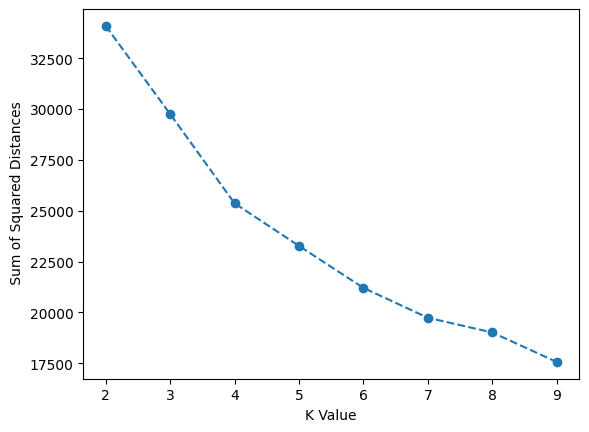

In [17]:
plt.plot(temp_range,ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances")

Анализируем **уменьшение** метрики SSD

In [18]:
ssd

[34082.84367923808,
 29755.37417575348,
 25366.0325533895,
 23271.281950182063,
 21207.558256039178,
 19739.371974958565,
 19016.204225080248,
 17567.34612855929]

In [19]:
# Изменение метрики SSD - текущее минус предыдущее значение! Ищем где изменение меньше, чем остальные
pd.Series(ssd).diff()

0            NaN
1   -4327.469503
2   -4389.341622
3   -2094.750603
4   -2063.723694
5   -1468.186281
6    -723.167750
7   -1448.858097
dtype: float64

In [20]:
pd.DataFrame(data=zip(temp_range,pd.Series(ssd).diff()),columns=['K','SSD diff'])

,K,SSD diff
0,2,NaN
1,3,-4327.469503
2,4,-4389.341622
3,5,-2094.750603
4,6,-2063.723694
5,7,-1468.186281
6,8,-723.167750
7,9,-1448.858097


<Axes: >

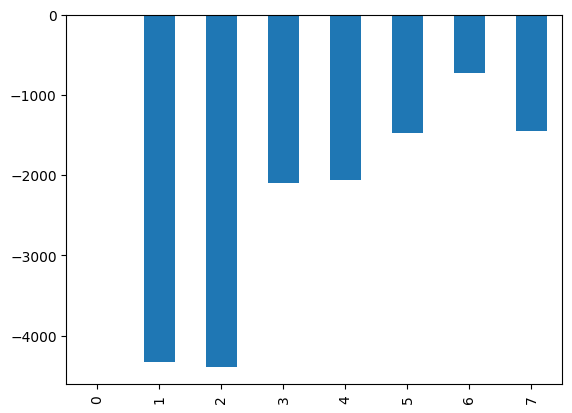

In [21]:
pd.Series(ssd).diff().plot(kind='bar')

In [22]:
from sklearn.metrics import silhouette_score

In [23]:
silhouettes = []
temp_range = range(2, 10)
for k in temp_range:
    model = KMeans(n_clusters=k, n_init="auto", random_state=10)
    model.fit(scaled_X)
    silhouettes.append(silhouette_score(scaled_X,model.labels_))
    print(f"{k} - {silhouette_score(scaled_X,model.labels_)}")

2 - 0.23579908242307482
3 - 0.1973530723824858
4 - 0.2231230779602855
5 - 0.17089912019298947
6 - 0.1843751384631508
7 - 0.18398497035063513
8 - 0.18989305180719845
9 - 0.19364136477686208


In [24]:
clusters_silhoettes = sorted(
    list(zip(temp_range, silhouettes)), key=lambda x: x[1], reverse=True
)
clusters_silhoettes

[(2, 0.23579908242307482),
 (4, 0.2231230779602855),
 (3, 0.1973530723824858),
 (9, 0.19364136477686208),
 (8, 0.18989305180719845),
 (6, 0.1843751384631508),
 (7, 0.18398497035063513),
 (5, 0.17089912019298947)]

For n_clusters = 2 The average silhouette_score is : 0.23579908242307482
For n_clusters = 3 The average silhouette_score is : 0.1973530723824858
For n_clusters = 4 The average silhouette_score is : 0.2231230779602855
For n_clusters = 5 The average silhouette_score is : 0.17089912019298947
For n_clusters = 6 The average silhouette_score is : 0.1843751384631508
For n_clusters = 7 The average silhouette_score is : 0.18398497035063513
For n_clusters = 8 The average silhouette_score is : 0.18989305180719845
For n_clusters = 9 The average silhouette_score is : 0.19364136477686208
[(2, 0.23579908242307482), (4, 0.2231230779602855), (3, 0.1973530723824858), (9, 0.19364136477686208), (8, 0.18989305180719845), (6, 0.1843751384631508), (7, 0.18398497035063513), (5, 0.17089912019298947)]


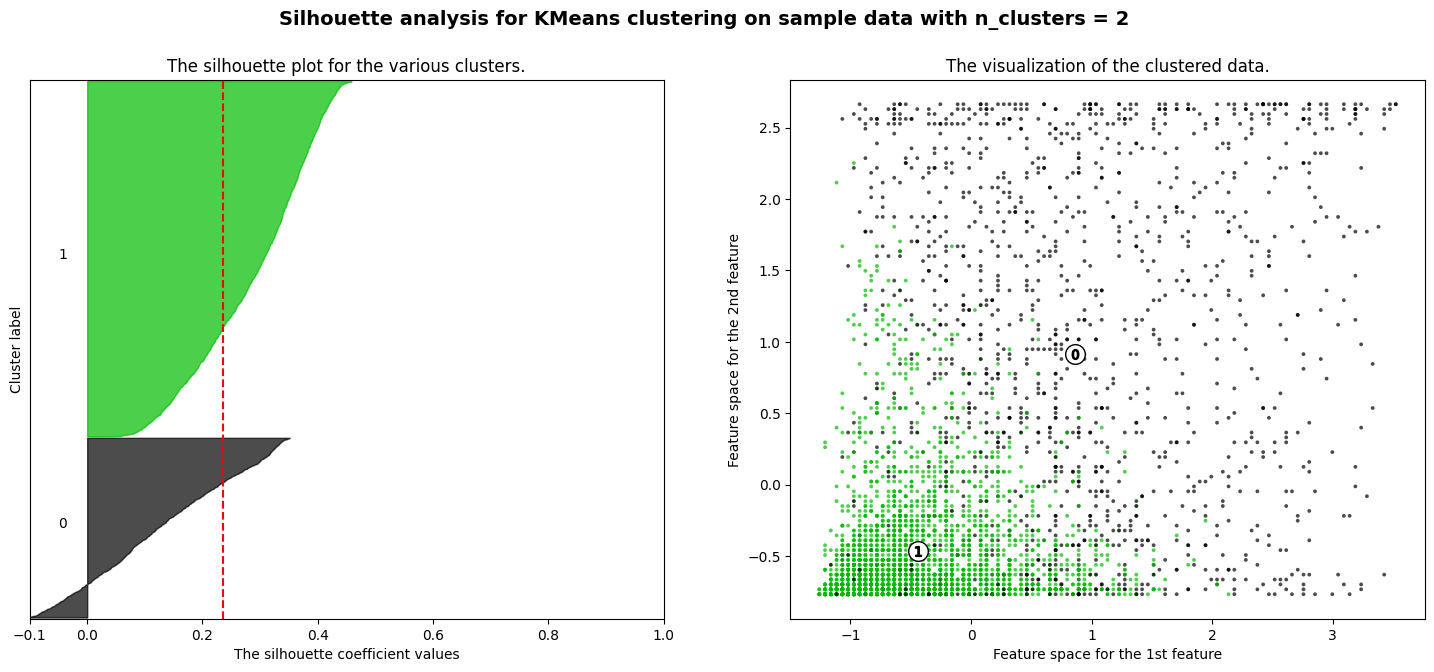

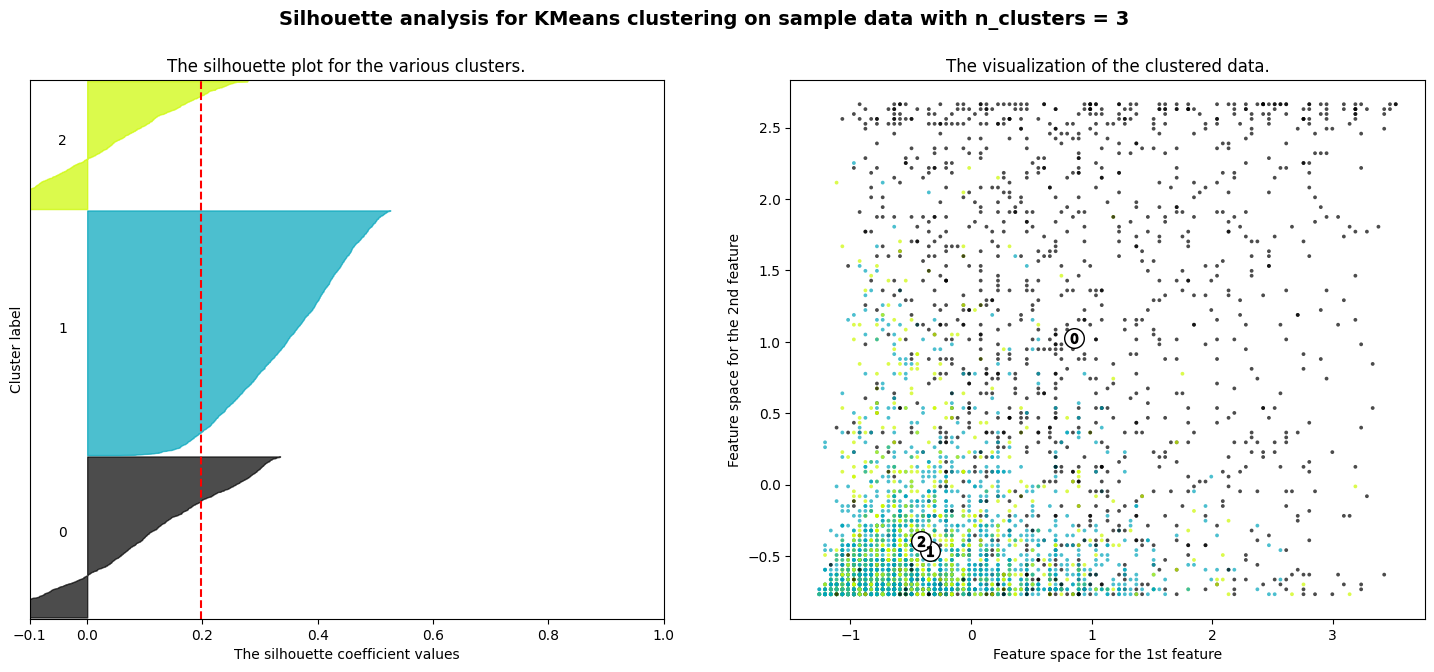

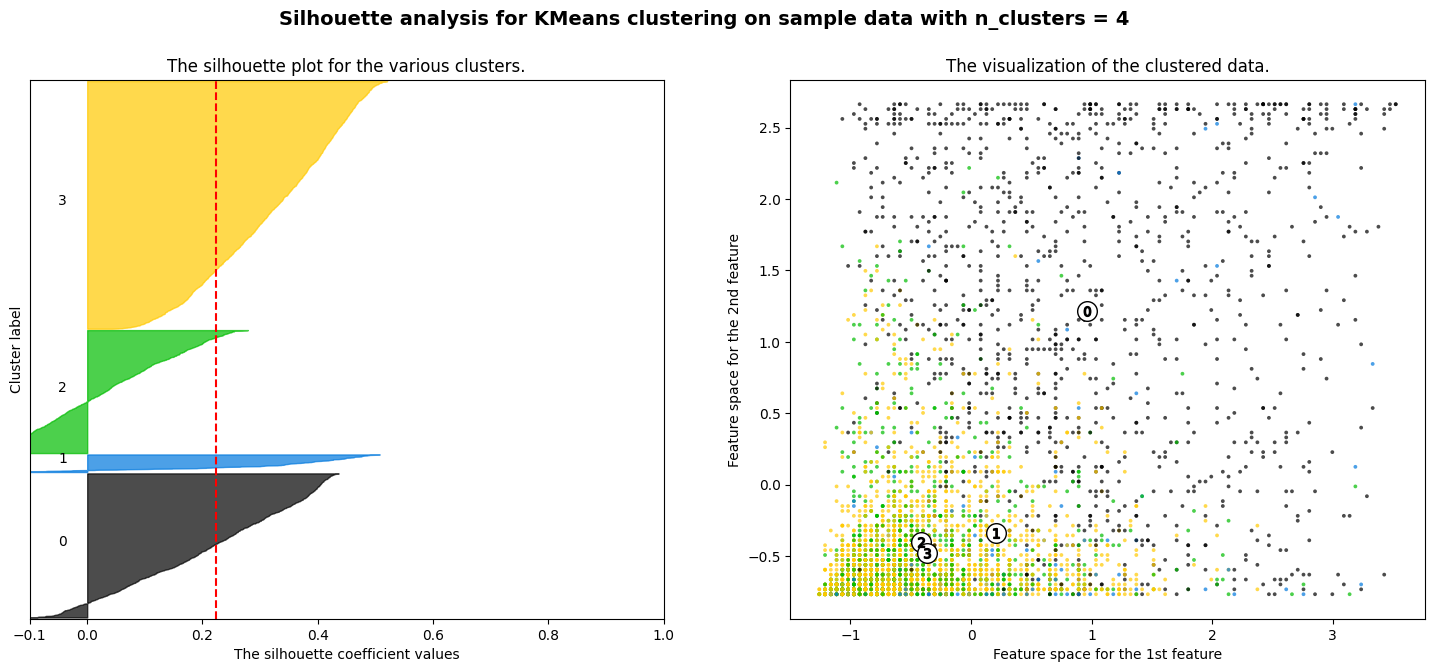

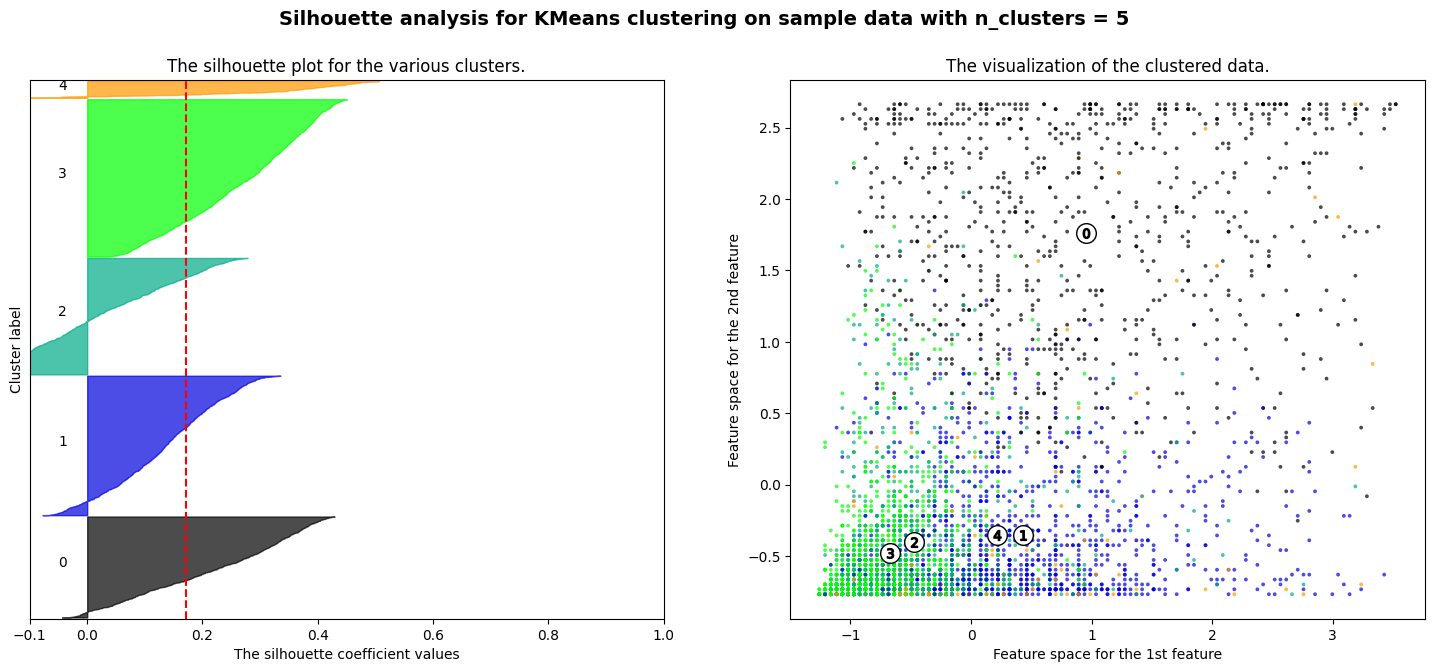

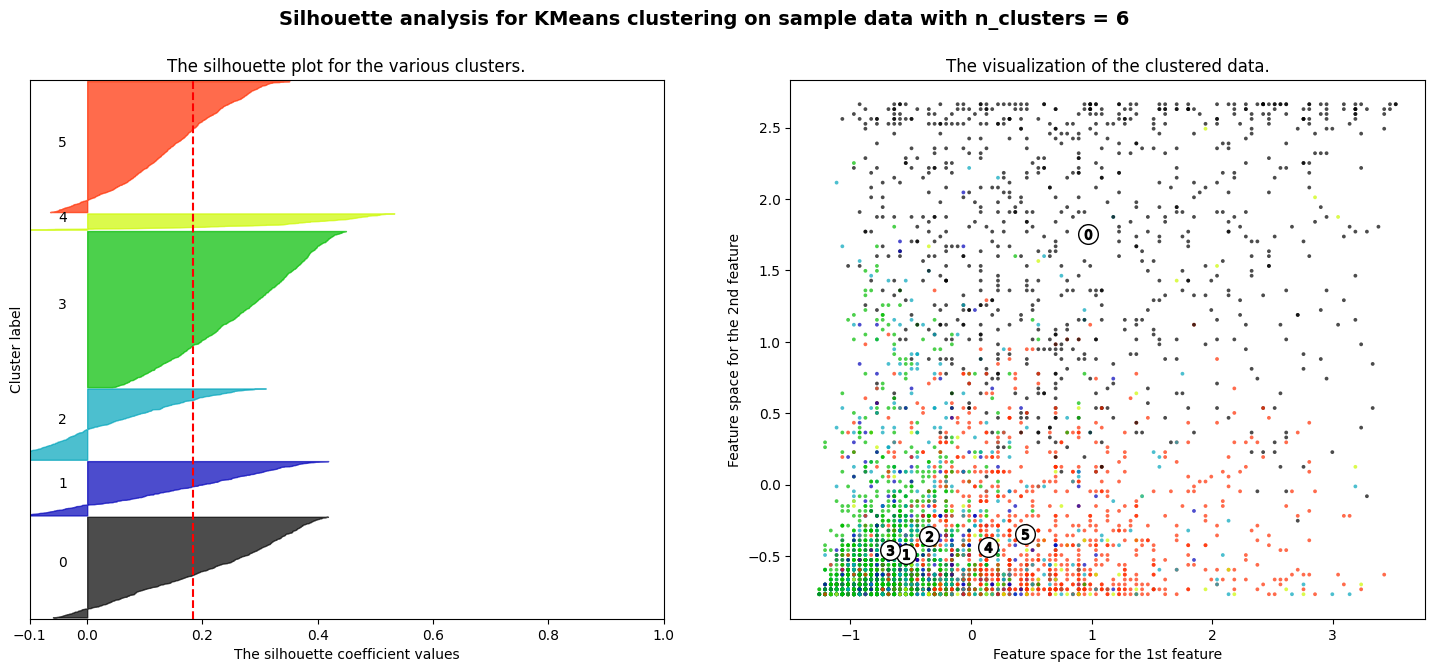

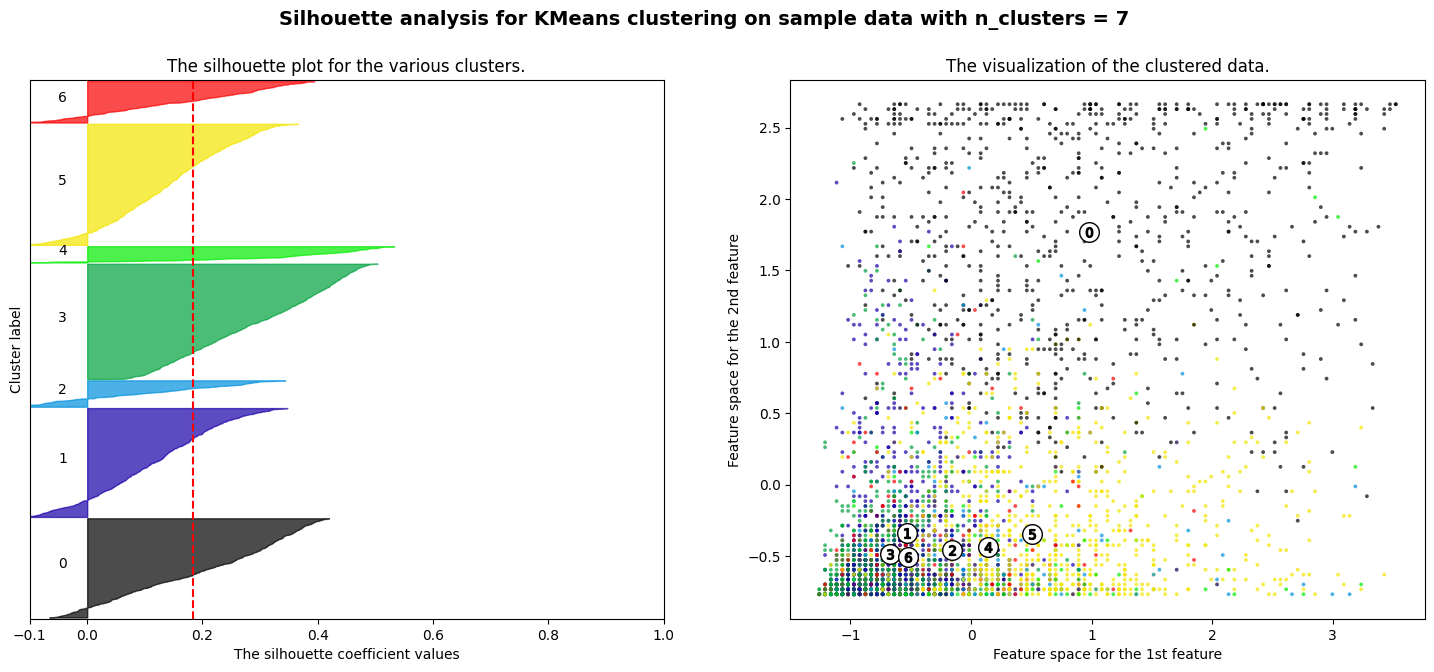

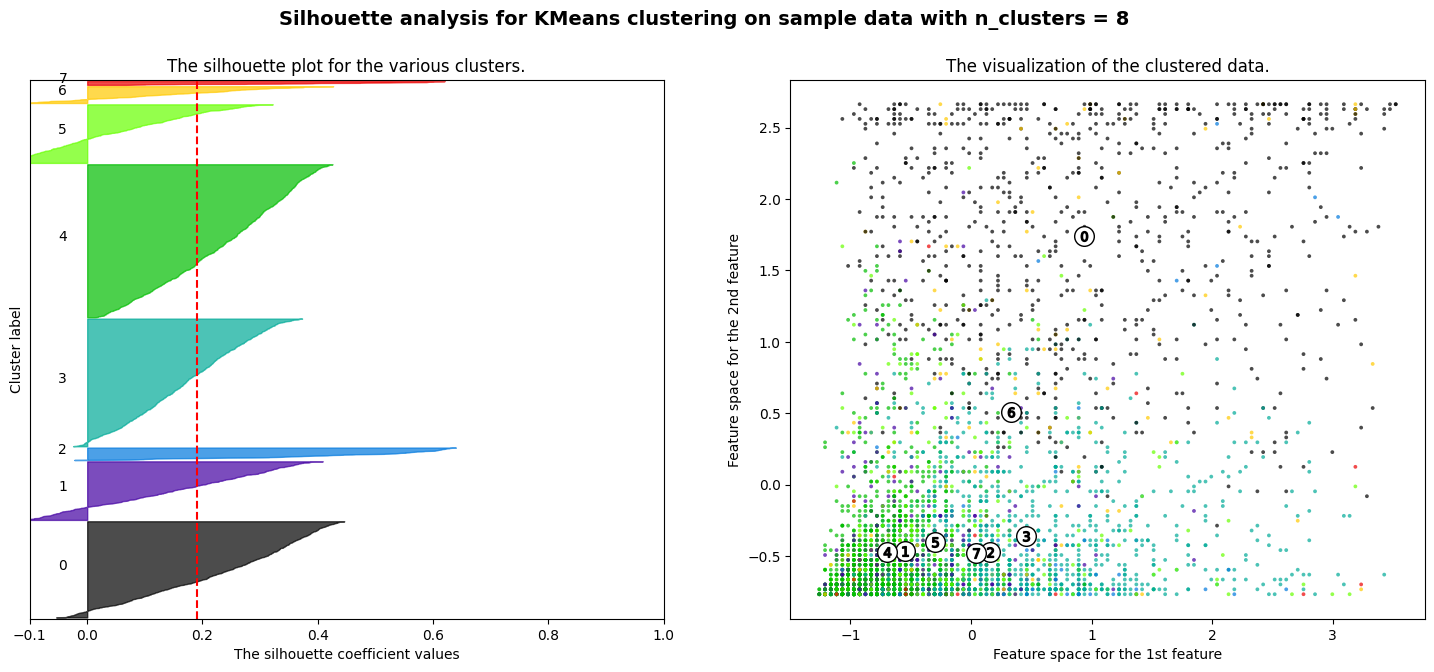

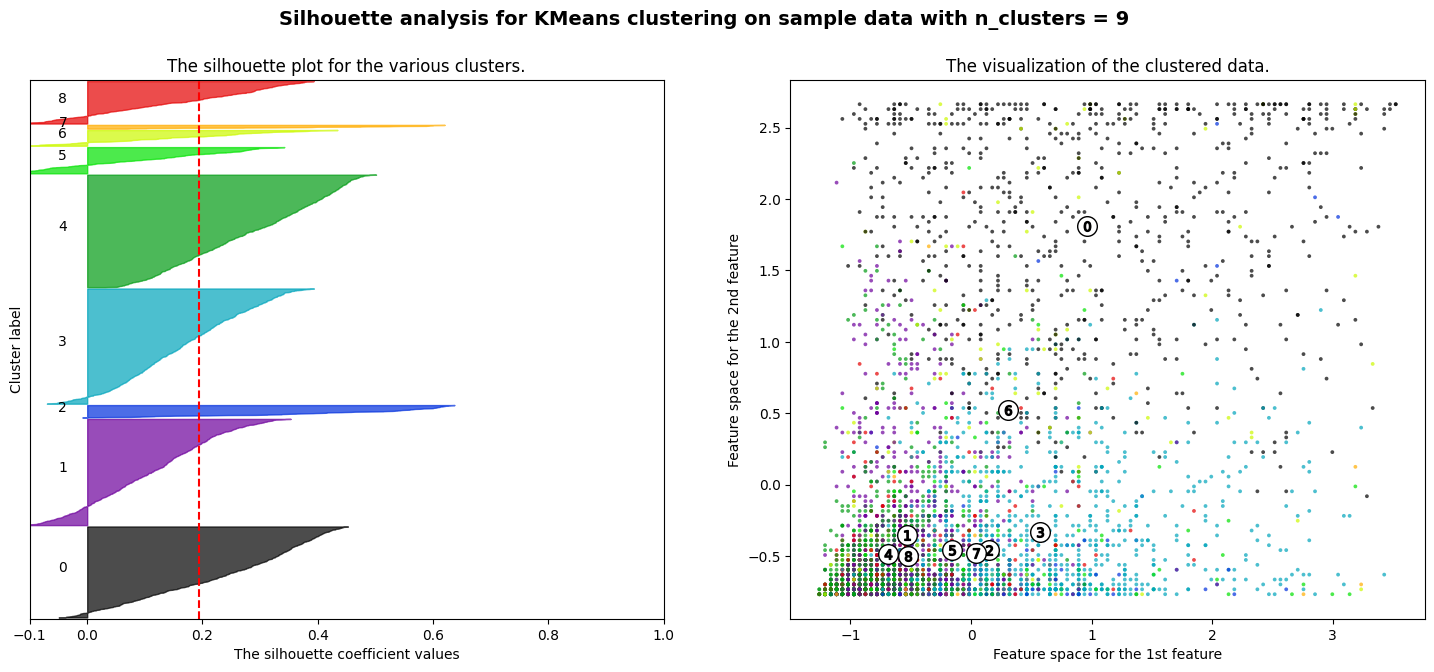

[(2, 0.23579908242307482), (4, 0.2231230779602855), (3, 0.1973530723824858), (9, 0.19364136477686208), (8, 0.18989305180719845), (6, 0.1843751384631508), (7, 0.18398497035063513), (5, 0.17089912019298947)]


In [25]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = scaled_X

score = []

# range_n_clusters = sorted([cluster for cluster, sil in clusters_silhoettes])
# range_n_clusters = [3]

range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    # clusterer = KMeans(n_clusters=n_clusters, n_init="auto")
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    df[f"Cluster{n_clusters}"] = cluster_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    score.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    
clusters_silhoettes = sorted(
    list(zip(temp_range, score)), key=lambda x: x[1], reverse=True
)
print(clusters_silhoettes)

plt.show()
print(clusters_silhoettes)

In [26]:
clusters_silhoettes

[(2, 0.23579908242307482),
 (4, 0.2231230779602855),
 (3, 0.1973530723824858),
 (9, 0.19364136477686208),
 (8, 0.18989305180719845),
 (6, 0.1843751384631508),
 (7, 0.18398497035063513),
 (5, 0.17089912019298947)]

In [40]:
cluster_count = 9

In [41]:
for n in range(2, cluster_count):
    display_clusters(df, n, False)

-----------------------2------------------------


,speft,negt,negft,skit,neut,skift,pt,pft,neuft,spet
0,0.943182,0.566691,0.448733,0.358786,0.301523,0.292689,0.283639,0.192884,0.160692,0.056929


-----------------------3------------------------


,speft,negt,skit,negft,skift,neut,pt,pft,neuft,spet
0,0.977311,0.845219,0.808706,0.504614,0.415759,0.29338,0.245607,0.148833,0.134903,0.050663


-----------------------4------------------------


,speft,negt,skit,negft,skift,spet,neut,pt,neuft,pft
0,1.363174,1.012989,0.837754,0.566913,0.415745,0.376704,0.309587,0.23708,0.13747,0.134645


-----------------------5------------------------


,speft,negt,skit,negft,skift,spet,neut,pt,neuft,pft
0,1.432357,0.951223,0.77669,0.531394,0.392388,0.34357,0.314159,0.281532,0.169154,0.139259


-----------------------6------------------------


,speft,negt,skit,negft,skift,spet,neut,pt,neuft,pft
0,1.439555,1.211808,0.940137,0.541346,0.429946,0.325151,0.282433,0.258917,0.147562,0.132846


-----------------------7------------------------


,speft,skit,negt,negft,skift,spet,neut,pt,neuft,pft
0,1.490215,1.235657,1.204856,0.533788,0.407975,0.301349,0.274138,0.242905,0.154633,0.128366


-----------------------8------------------------


,speft,negt,skit,negft,skift,spet,neut,pt,neuft,pft
0,1.546668,1.232406,0.990662,0.640928,0.446219,0.371831,0.272809,0.232468,0.154837,0.113919


In [42]:
df_means = display_clusters(df, cluster_count, False)

-----------------------9------------------------


,speft,negt,skit,negft,skift,spet,neut,pt,neuft,pft
0,1.624487,1.269458,1.258751,0.624447,0.426359,0.353878,0.270973,0.226527,0.163199,0.115325


In [43]:
reorder_df(df_means)

,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet
0,0.382630,0.125390,0.178485,0.638799,0.123669,0.082165,0.076591,0.044870,0.034318,0.009275
1,0.293960,0.089307,0.120990,0.047723,0.109802,0.015644,0.082277,0.033267,0.126238,0.805446
2,0.152477,0.120352,0.279988,0.564378,0.259272,0.098462,0.169918,0.083134,0.015845,0.008345
3,0.327323,0.372441,0.044252,0.295984,0.064961,0.069685,0.066850,0.042992,0.384488,0.042913
4,0.153284,0.077009,0.270088,0.393109,0.367713,0.496774,0.132815,0.087566,0.017947,0.004868
5,0.118902,0.082650,0.567550,0.809435,0.161164,0.078337,0.084468,0.040377,0.010266,0.002306
6,0.465178,0.749466,0.162315,0.124151,0.121781,0.048658,0.082205,0.035192,0.032247,0.006452
7,0.229668,0.089621,0.244929,0.369716,0.196209,0.125545,0.182607,0.379005,0.025261,0.003270
8,0.271613,0.083226,0.018065,0.031935,0.047742,0.026452,0.068387,0.046452,0.739677,0.820645


# Исследуем конкретное количество кластеров

In [44]:
cluster_col_name = "Cluster" + str(cluster_count)

## Тестируем разбиение на кластеры

In [45]:
clusterer = KMeans(n_clusters=cluster_count, n_init="auto", random_state=10)
clusterer.fit_predict(scaled_X)

array([3, 3, 3, ..., 4, 4, 4])

In [46]:
df_ohot = get_one_hot(cluster_col_name, df)
df_ohot = df_ohot.drop([col for col in df.columns if "Cluster" in col and cluster_col_name not in col], axis = 1)

In [47]:
df_cluster = df
df_cluster = df_cluster.drop([col for col in df.columns if "Cluster" in col and cluster_col_name not in col], axis = 1)

In [48]:
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

def make_n_gramms(df):
    df_nouns = df
    if type(df_nouns["raw"].iloc[0]) is str:
        df_nouns.loc[:,"raw"] = df_nouns["raw"].apply(ast.literal_eval)
    df_nouns["noun"] = df_nouns["raw"].apply(lambda x: 
        [
            item[0]
            for item in x
            if not (item[0] in stopwords_ru or re.search(rf"\d|[{punctuation}]", item[0]))
            and item[1] == "NOUN"
        ])
    df_nouns = df_nouns.explode("noun")

    df_x = df_nouns.groupby(["noun"])["text"].agg({
        ". ".join,
    })
    df_x.columns = [col[0] for col in df_x.columns]
    # df_x[df_x.columns[0]].agg(len).sort_values(ascending=False)
    df_nouns = pd.DataFrame(df_x[df_x.columns[0]])
    df_nouns["len"] = df_nouns["j"].agg(len)
    df_nouns = df_nouns.sort_values("len", ascending=False)
    def get_counts(corpus):
        try:
            regex = re.compile(r"(\sне)\s", re.IGNORECASE)
            corpus = regex.sub(r"\g<1>", corpus)
            
            doc_corpus = Doc(corpus)
            doc_corpus.segment(segmenter)
            doc_corpus.tag_morph(morph_tagger)
            doc_corpus.parse_syntax(syntax_parser)
            doc_corpus.tag_morph(morph_tagger)
            for token in doc_corpus.tokens:
                token.lemmatize(morph_vocab)
            data_natasha = doc_corpus.tokens
            columns = list(doc_corpus.tokens[0].as_json.keys())
            df_natasha = pd.DataFrame(data=data_natasha, columns=columns)
            
            df_adj = df_natasha[df_natasha["pos"] == "ADJ"]
            if len(df_adj.index) == 0:
                return []
            
            cv = CountVectorizer()   
            cv_fit = cv.fit_transform(df_adj['lemma'])    
            word_list = cv.get_feature_names_out() 
            count_list = cv_fit.toarray().sum(axis=0)
            df_counts = pd.DataFrame.from_dict(zip(word_list,count_list))
            df_counts = df_counts.rename({0: 'token', 1: 'count'}, axis=1)
            df_counts = df_counts.sort_values(["count"], ascending=False)
            df_counts = df_counts[df_counts["count"] > 2]
            
            return df_counts.to_dict('tight')["data"]
        except:
            return []
    noun_lemmas = df_nouns["j"].agg(get_counts)
    return pd.DataFrame(noun_lemmas)

In [49]:
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 25)

In [50]:
df_clusters_counts = [make_n_gramms(df_cluster[df_cluster["Cluster" + str(cluster_count)] == i]) for i in range(cluster_count)]

In [51]:
# pd.reset_option('max_colwidth')

In [58]:
df_cluster_counts

,j
noun,
горшок,[]
товар,"[[ужасный, 3]]"
упаковка,"[[плохой, 3], [прозрачный, 3]]"
брак,"[[ужасный, 3]]"
отзыв,"[[плохой, 3]]"
...,...
коврик,[]
свинство,[]
цена,[]


In [74]:
df_cluster_sub = df_cluster[(df_cluster["Cluster" + str(cluster_count)] == 8)]
df_neg_temp = make_n_gramms(df_cluster_sub)
df_neg_res = df_neg_temp[df_neg_temp["j"].agg(len) > 0]
df_neg_res

,j
noun,
товар,"[[ужасный, 3]]"
упаковка,"[[плохой, 3], [прозрачный, 3]]"
брак,"[[ужасный, 3]]"
отзыв,"[[плохой, 3]]"
пакет,"[[обычный, 3]]"
размер,"[[больший, 3]]"


In [75]:
df_cluster_sub2 = df_cluster[
    (df_cluster["Cluster" + str(cluster_count)] != 2)
    & (df_cluster["Cluster" + str(cluster_count)] != 7)
    & (df_cluster["Cluster" + str(cluster_count)] != 8)
]
df_pos_temp = make_n_gramms(df_cluster_sub2)
df_pos_res = df_pos_temp[df_pos_temp["j"].agg(len) > 0]
df_pos_res

,j
noun,
горшок,"[[красивый, 29], [хороший, 20], [маленький, 15], [внутренний, 14], [отличный, 14], [небольшой, 10], [большой, 9], [удобный, 9], [классный, 8], [цветочный, 8], [прекрасный, 7], [больший, 7], [средний, 7], [симпатичный, 6], [другой, 6], [белый, 6], [нужный, 6], [разный, 6], [огромный, 5], [сам, 5], [черный, 5], [горшок, 5], [первый, 4], [самый, 4], [прозрачный, 4], [высокий, 4], [второй, 4], [це..."
лампа,"[[удобный, 18], [хороший, 13], [сам, 13], [отличный, 12], [полный, 9], [нужный, 9], [неплохой, 9], [первый, 8], [рабочий, 8], [довольный, 8], [классный, 8], [качественный, 7], [замечательный, 7], [крепкий, 6], [другой, 6], [второй, 6], [красный, 5], [разный, 5], [технический, 5], [данный, 4], [синий, 4], [больший, 4], [приятный, 4], [лампа, 3], [лабораторный, 3], [розовый, 3], [небольшой, 3], ..."
цвет,"[[белый, 27], [красивый, 14], [другой, 12], [приятный, 10], [черный, 9], [маленький, 8], [разный, 8], [отличный, 8], [небольшой, 8], [серый, 7], [хороший, 7], [удобный, 6], [розовый, 6], [молочный, 5], [сиреневый, 5], [яркий, 5], [сам, 4], [самый, 4], [прочный, 4], [симпатичный, 4], [комнатный, 4], [целый, 4], [нужный, 3], [мягкий, 3], [качественный, 3], [довольный, 3], [красный, 3], [высокий,..."
товар,"[[качественный, 19], [довольный, 14], [данный, 9], [целый, 7], [хороший, 5], [браковать, 5], [нужный, 4], [полный, 4], [сам, 4], [должный, 3], [нормальный, 3], [мелкий, 3], [обидный, 3], [большой, 3]]"
продавец,"[[приятный, 4], [большой, 4], [быстрый, 4], [качественный, 4], [другой, 4], [маленький, 3], [красивый, 3], [полный, 3]]"
...,...
оттенок,"[[белый, 3]]"
любовь,"[[первый, 3]]"
кислота,"[[борный, 3]]"


In [78]:
df_neg_res.to_csv("../data/data_negative.csv")

In [79]:
df_pos_res.to_csv("../data/data_positive.csv")

In [ ]:
indexer = 1
df_neg = None
for df_cluster_counts in df_clusters_counts:
    if indexer in [3,8]:
        continue
    if indexer == 9:
        df_neg = df_cluster_counts[df_cluster_counts["j"].agg(len) > 0]
        continue
    
    df_cluster[df_cluster["Cluster" + str(cluster_count)] == indexer-1]
    display(df_cluster_counts[df_cluster_counts["j"].agg(len) > 0])
    indexer += 1

In [70]:
indexer = 1
for df_cluster_counts in df_clusters_counts:
    print(f"-----------------------{indexer}------------------------")
    display(df_cluster[df_cluster["Cluster" + str(cluster_count)] == indexer-1])
    display(df_cluster_counts[df_cluster_counts["j"].agg(len) > 0])
    indexer += 1

-----------------------1------------------------


,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet,Cluster9
22,Отличные ящики очень довольна,"Отличные ящики, купила 4 шт, очень довольна. На широкую стенку искала. Гайки надо затягивать сильно, придерживая с обратной стороны плоскогубцами.","['amod', 'nsubj', 'advmod', 'root']","['ADJ', 'NOUN', 'ADV', 'ADJ']","['отличный', 'ящик', 'очень', 'довольный']","[('отличный', 'ADJ', 'amod'), ('ящик', 'NOUN', 'nsubj'), ('очень', 'ADV', 'advmod'), ('довольный', 'ADJ', 'root')]",0.19,0.99,0.32,0.00,0.15,0.04,0.11,0.01,0.00,0.00,0
25,Благодарю за качественный товар,"Крепление идеально закрепилось на перилах балкона , ящик с цветами так же идеально вошел. Благодарю за качественный товар и быструю доставку!","['root', 'case', 'amod', 'obl']","['VERB', 'ADP', 'ADJ', 'NOUN']","['благодарить', 'за', 'качественный', 'товар']","[('благодарить', 'VERB', 'root'), ('за', 'ADP', 'case'), ('качественный', 'ADJ', 'amod'), ('товар', 'NOUN', 'obl')]",0.81,0.21,0.07,0.06,0.05,0.02,0.07,0.12,0.03,0.02,0
28,О это очень классные удобные крепления,"О, это очень классные удобные и прочные крепления! Заказала 4 шт.сразу, все в идеальном состочнии!","['parataxis', 'nsubj', 'advmod', 'amod', 'amod', 'conj']","['INTJ', 'PART', 'ADV', 'ADJ', 'ADJ', 'NOUN']","['о', 'это', 'очень', 'классный', 'удобный', 'крепление']","[('о', 'INTJ', 'parataxis'), ('это', 'PART', 'nsubj'), ('очень', 'ADV', 'advmod'), ('классный', 'ADJ', 'amod'), ('удобный', 'ADJ', 'amod'), ('крепление', 'NOUN', 'conj')]",0.67,0.96,0.08,0.01,0.14,0.02,0.01,0.00,0.01,0.00,0
30,Хороший держатель можно подогнать под разную ширину перил,"Хороший держатель, крепление можно подогнать под разную ширину перил. Выдержал ящик с землей, конструкция довольно крепкая. Размеры соответствуют","['amod', 'nsubj', 'root', 'csubj', 'case', 'amod', 'obl', 'nmod']","['ADJ', 'NOUN', 'ADV', 'VERB', 'ADP', 'ADJ', 'NOUN', 'NOUN']","['хороший', 'держатель', 'можно', 'подогнать', 'под', 'разный', 'ширина', 'перила']","[('хороший', 'ADJ', 'amod'), ('держатель', 'NOUN', 'nsubj'), ('можно', 'ADV', 'root'), ('подогнать', 'VERB', 'csubj'), ('под', 'ADP', 'case'), ('разный', 'ADJ', 'amod'), ('ширина', 'NOUN', 'obl'), ('перила', 'NOUN', 'nmod')]",0.19,0.54,0.41,0.17,0.20,0.04,0.05,0.06,0.01,0.00,0
31,конструкция довольно крепкая,"Хороший держатель, крепление можно подогнать под разную ширину перил. Выдержал ящик с землей, конструкция довольно крепкая. Размеры соответствуют","['nsubj', 'advmod', 'conj']","['NOUN', 'ADV', 'ADJ']","['конструкция', 'довольно', 'крепкий']","[('конструкция', 'NOUN', 'nsubj'), ('довольно', 'ADV', 'advmod'), ('крепкий', 'ADJ', 'conj')]",0.19,0.48,0.41,0.14,0.20,0.20,0.05,0.01,0.01,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,Очень удобная лампа,Очень удобная лампа. Охватывает большой радиус освещения. Три цвета асаещения подходят для любой фазы развития растений. Спасибо,"['advmod', 'amod', 'root']","['ADV', 'ADJ', 'NOUN']","['очень', 'удобный', 'лампа']","[('очень', 'ADV', 'advmod'), ('удобный', 'ADJ', 'amod'), ('лампа', 'NOUN', 'root')]",0.08,0.95,0.12,0.03,0.05,0.02,0.07,0.00,0.10,0.00,0
4181,Хорошая лампа работает хорошо синий свет,"Хорошая лампа, доставка быстрая, работает хорошо - синий, красный, розовый свет. Поможет ли это растениям не знаю, но покупкой довольна","['amod', 'nsubj', 'root', 'advmod', 'parataxis', 'nsubj']","['ADJ', 'NOUN', 'VERB', 'ADV', 'ADJ', 'NOUN']","['хороший', 'лампа', 'работать', 'хорошо', 'синий', 'свет']","[('хороший', 'ADJ', 'amod'), ('лампа', 'NOUN', 'nsubj'), ('работать', 'VERB', 'root'), ('хорошо', 'ADV', 'advmod'), ('синий', 'ADJ', 'parataxis'), ('свет', 'NOUN', 'nsubj')]",0.52,0.92,0.06,0.00,0.06,0.01,0.13,0.25,0.01,0.00,0
4192,удобный держатель,"Отличная лампа, удобный держатель, очень нравиться гибкость ламп, что позволяет увеличить или уменьшить расстояние.","['amod', 'conj']","['ADJ', 'NOUN']","['удобный', 'держатель']","[('удобный', 'ADJ', 'amod'), ('держатель', 'NOUN', 'conj')]",0.75,0.9

,j
noun,
горшок,"[[красивый, 19], [хороший, 12], [отличный, 8], [классный, 7], [прекрасный, 5], [маленький, 4], [симпатичный, 4], [качественный, 3], [цветочный, 3]]"
горшочек,"[[хороший, 13], [красивый, 13], [горшочек, 10], [классный, 9], [удобный, 8], [замечательный, 8], [маленький, 8], [самый, 5], [небольшой, 3], [стильный, 3], [симпатичный, 3], [отличный, 3], [милый, 3]]"
лампа,"[[удобный, 10], [хороший, 9], [отличный, 8], [классный, 8], [замечательный, 6], [довольный, 5], [качественный, 5], [приятный, 4]]"
цвет,"[[красивый, 10], [приятный, 8], [отличный, 6], [хороший, 4], [удобный, 3], [качественный, 3], [сам, 3], [небольшой, 3]]"
подарок,"[[отличный, 4], [хороший, 3], [самый, 3], [приятный, 3]]"
...,...
адаптер,"[[хороший, 3]]"
система,"[[удобный, 4]]"
вид,"[[приятный, 3]]"


-----------------------2------------------------


,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet,Cluster9
5,Спасибо за маленький сюрприз как внимание к покупателю,"Отличные ящики, к качеству и упаковке претензий нет. Спасибо за маленький сюрприз, как внимание к покупателю!","['root', 'case', 'amod', 'obl', 'case', 'nsubj', 'case', 'nmod']","['NOUN', 'ADP', 'ADJ', 'NOUN', 'SCONJ', 'NOUN', 'ADP', 'NOUN']","['спасибо', 'за', 'маленький', 'сюрприз', 'как', 'внимание', 'к', 'покупатель']","[('спасибо', 'NOUN', 'root'), ('за', 'ADP', 'case'), ('маленький', 'ADJ', 'amod'), ('сюрприз', 'NOUN', 'obl'), ('как', 'SCONJ', 'case'), ('внимание', 'NOUN', 'nsubj'), ('к', 'ADP', 'case'), ('покупатель', 'NOUN', 'nmod')]",0.09,0.00,0.06,0.18,0.10,0.02,0.18,0.10,0.13,0.33,1
8,Невооружённым взглядом были видны сколы,"Возможность оценить не предоставилась. Даже не распаковывала. Завернуты были в полиэтилен. Невооружённым взглядом были видны сколы. Естественно забирать не стала. ""Приятным"" бонусом было списание денег за возврат.","['amod', 'obl', 'cop', 'root', 'nsubj']","['VERB', 'NOUN', 'AUX', 'ADJ', 'NOUN']","['невооруженный', 'взгляд', 'быть', 'видный', 'скол']","[('невооруженный', 'VERB', 'amod'), ('взгляд', 'NOUN', 'obl'), ('быть', 'AUX', 'cop'), ('видный', 'ADJ', 'root'), ('скол', 'NOUN', 'nsubj')]",0.18,0.12,0.34,0.41,0.40,0.06,0.08,0.05,0.00,0.00,1
10,Маленький презент был сюрпризом Рекомендую к покупке,"Ящички довольно-таки большие. Думала будут меньше. Хороший, крепкий пластик. Маленький презент, был сюрпризом.Рекомендую к покупке. Подойдёт для выращивания на подоконнике зелени.","['amod', 'nsubj', 'cop', 'root', 'parataxis', 'case', 'obl']","['ADJ', 'NOUN', 'AUX', 'NOUN', 'VERB', 'ADP', 'NOUN']","['маленький', 'презент', 'быть', 'сюрприз', 'рекомендовать', 'к', 'покупка']","[('маленький', 'ADJ', 'amod'), ('презент', 'NOUN', 'nsubj'), ('быть', 'AUX', 'cop'), ('сюрприз', 'NOUN', 'root'), ('рекомендовать', 'VERB', 'parataxis'), ('к', 'ADP', 'case'), ('покупка', 'NOUN', 'obl')]",0.14,0.13,0.30,0.52,0.06,0.03,0.29,0.20,0.01,0.00,1
11,Подойдёт для выращивания на подоконнике зелени,"Ящички довольно-таки большие. Думала будут меньше. Хороший, крепкий пластик. Маленький презент, был сюрпризом.Рекомендую к покупке. Подойдёт для выращивания на подоконнике зелени.","['root', 'case', 'nmod', 'case', 'nmod', 'nmod']","['ADJ', 'ADP', 'NOUN', 'ADP', 'NOUN', 'NOUN']","['подойти', 'для', 'выращивание', 'на', 'подоконник', 'зелень']","[('подойти', 'ADJ', 'root'), ('для', 'ADP', 'case'), ('выращивание', 'NOUN', 'nmod'), ('на', 'ADP', 'case'), ('подоконник', 'NOUN', 'nmod'), ('зелень', 'NOUN', 'nmod')]",0.14,0.00,0.30,0.99,0.06,0.02,0.29,0.09,0.01,0.00,1
18,что само крепление не тяжёлое,"Главное для меня, что само крепление не тяжёлое и может варьироваться на разную ширину перил. Позднее хочу заказать ещё парочку.","['mark', 'amod', 'nsubj', 'advmod', 'root']","['SCONJ', 'ADJ', 'NOUN', 'PART', 'ADJ']","['что', 'сам', 'крепление', 'не', 'тяжелый']","[('что', 'SCONJ', 'mark'), ('сам', 'ADJ', 'amod'), ('крепление', 'NOUN', 'nsubj'), ('не', 'PART', 'advmod'), ('тяжелый', 'ADJ', 'root')]",0.08,0.16,0.36,0.14,0.21,0.22,0.16,0.01,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4210,упаковки у всех ламп но а я их 8 забрала и раскурочены,"Всё работает, но упаковки у всех ламп (а я их 8 забрала) раскурочены и на 100 раз скотчем перемотаны. А так все детали на месте.","['obj', 'case', 'det', 'nmod', 'cc', 'cc', 'nsubj', 'obj', 'nummod', 'parataxis', 'cc', 'root']","['NOUN', 'ADP', 'DET', 'NOUN', 'CCONJ', 'CCONJ', 'PRON', 'PRON', 'ADJ', 'VERB', 'CCONJ', 'NOUN']","['упаковка', 'у', 'весь', 'лампа', 'но', 'а', 'я', 'они', '8', 'забрать', 'и', 'раскурочены']","[('упаковка', 'NOUN', 'obj'), ('у', 'ADP', 'case'), ('весь', 'DET', 'det'), ('лампа', 'NOUN', 'nmod'), ('но', 'CCONJ', 'cc'), ('а', 'CCONJ', 'cc'), ('я', 'PRON', 'nsubj'), ('они', 'PRON', 'obj'), ('8', 'ADJ', 'nummod'), ('забрать', 'VERB', 'parataxis'), ('и', 'CCONJ', 'cc'), ('раскурочен

,j
noun,
горшок,"[[внутренний, 9], [большой, 6], [маленький, 5], [красивый, 3], [целый, 3], [цветочный, 3], [хороший, 3], [отличный, 3], [нижний, 3]]"
лампа,"[[другой, 4], [нужный, 3], [отличный, 3], [больший, 3], [неплохой, 3], [красный, 3]]"
товар,"[[данный, 5], [браковать, 3], [качественный, 3], [должный, 3], [сам, 3], [нужный, 3], [хороший, 3], [целый, 3]]"
коробка,"[[картонный, 6], [хороший, 3], [первый, 3]]"
цвет,"[[белый, 6], [молочный, 3]]"
...,...
вставка,"[[внутренний, 3]]"
пленка,"[[пупырчатый, 3]]"
мл,"[[внутренний, 4]]"


-----------------------3------------------------


,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet,Cluster9
4,Отдельное спасибо продавцу за подарок,"Взяла эти ящики для рассады и не пожалела. Пластик прочный, есть съёмный поддон, идеальные размеры, красивый внешний вид. Отдельное спасибо продавцу за подарок и упаковку товара. Однозначно рекомендую!","['amod', 'root', 'iobj', 'case', 'nmod']","['ADJ', 'NOUN', 'NOUN', 'ADP', 'NOUN']","['отдельный', 'спасибо', 'продавец', 'за', 'подарок']","[('отдельный', 'ADJ', 'amod'), ('спасибо', 'NOUN', 'root'), ('продавец', 'NOUN', 'iobj'), ('за', 'ADP', 'case'), ('подарок', 'NOUN', 'nmod')]",0.21,0.01,0.14,0.13,0.08,0.00,0.10,0.01,0.04,0.73,2
13,все целое отдельное спасибо за подарок внутри,"Супер ящики, пришло все целое, хорошо упаковано, растения будут рады, отдельное спасибо за подарок внутри, мелочь, а приятно.","['det', 'amod', 'amod', 'conj', 'case', 'nmod', 'advmod']","['DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'ADV']","['весь', 'целый', 'отдельный', 'спасибо', 'за', 'подарок', 'внутри']","[('весь', 'DET', 'det'), ('целый', 'ADJ', 'amod'), ('отдельный', 'ADJ', 'amod'), ('спасибо', 'NOUN', 'conj'), ('за', 'ADP', 'case'), ('подарок', 'NOUN', 'nmod'), ('внутри', 'ADV', 'advmod')]",0.40,0.01,0.01,0.03,0.04,0.01,0.06,0.07,0.41,0.87,2
55,Отдельное спасибо за качественную упаковку,"Товаром очень довольна! Пластик крепкий, все отверстия для стока лишней воды есть. Поддон защелкивается и держится крепко. При перемещении не надо поддерживать руками. Внешне смотрится очень эстетично. К покупке рекомендую . Отдельное спасибо за качественную упаковку и быструю доставку.","['amod', 'root', 'case', 'amod', 'nmod']","['ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN']","['отдельный', 'спасибо', 'за', 'качественный', 'упаковка']","[('отдельный', 'ADJ', 'amod'), ('спасибо', 'NOUN', 'root'), ('за', 'ADP', 'case'), ('качественный', 'ADJ', 'amod'), ('упаковка', 'NOUN', 'nmod')]",0.18,0.06,0.23,0.00,0.11,0.01,0.11,0.09,0.02,0.78,2
108,Спасибо за качественный товар,"Очень понравились ящики, цвет яркий насыщенный, отличного качества, упакованы в коробку, пришли целые, без повреждений, рекомендую. Спасибо за качественный товар и быструю доставку!","['root', 'case', 'amod', 'obl']","['NOUN', 'ADP', 'ADJ', 'NOUN']","['спасибо', 'за', 'качественный', 'товар']","[('спасибо', 'NOUN', 'root'), ('за', 'ADP', 'case'), ('качественный', 'ADJ', 'amod'), ('товар', 'NOUN', 'obl')]",0.50,0.11,0.04,0.00,0.03,0.00,0.11,0.07,0.18,0.84,2
237,Спасибо большое за хороший товар,"Доставили даже раньше. Правда упакован был только в тонкую пленку, видимо распаковали уже.\n Главное целый, без каких либо повреждений. Материал плотный, качественный, все аккуратно и приятный на вид. Спасибо большое за хороший и качественный товар!","['root', 'amod', 'case', 'amod', 'obj']","['NOUN', 'ADJ', 'ADP', 'ADJ', 'NOUN']","['спасибо', 'большой', 'за', 'хороший', 'товар']","[('спасибо', 'NOUN', 'root'), ('большой', 'ADJ', 'amod'), ('за', 'ADP', 'case'), ('хороший', 'ADJ', 'amod'), ('товар', 'NOUN', 'obj')]",0.36,0.01,0.04,0.00,0.14,0.00,0.14,0.03,0.06,0.99,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,Спасибо за быструю отправку,"Спасибо за быструю отправку и доставку! Фитолампа с таймером на 3,9,12 ч. Все отлично работает, яркость подсветки можно изменить, режимы переключаются, адаптер в комплекте. Только не было инструкции (она наверное не предусмотрена, т к все указано на коробке). Но вот технические характеристики мощности ламп не нашла ни на коробке ни на лампах ( где найти точную информацию?).\n Светит хорошо.....","['root', 'case', 'amod', 'obl']","['NOUN', 'ADP', 'ADJ', 'NOUN']","['спасибо', 'за', 'быстрый', 'отправка']","[('спасибо', 'NOUN', 'root'), ('за', 'ADP', 'case'), ('быстрый', 'ADJ', 'amod'), ('отправка', 'NOUN', 'obl')]",0.29,0.00,0.25,0.00,0.09,0.00,0.08,0.06,0.01,0.93,2
4082,Пока досвечиваю комнатные растюхи Большое спасибо продавцу 🌷,Отличная лампа. Пришла быстро. Брала для рассады. Пока досвечиваю комнатные растюхи

,j
noun,
спасибо,"[[большой, 29], [огромный, 14], [отдельный, 14], [качественный, 10], [целый, 3], [хороший, 3], [приятный, 3]]"
производитель,"[[огромный, 5], [большой, 4]]"
товар,"[[качественный, 7], [огромный, 3]]"
подарок,"[[отдельный, 7], [большой, 3]]"


-----------------------4------------------------


,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet,Cluster9
0,Пластик прочный,"Взяла эти ящики для рассады и не пожалела. Пластик прочный, есть съёмный поддон, идеальные размеры, красивый внешний вид. Отдельное спасибо продавцу за подарок и упаковку товара. Однозначно рекомендую!","['nsubj', 'root']","['NOUN', 'ADJ']","['пластик', 'прочный']","[('пластик', 'NOUN', 'nsubj'), ('прочный', 'ADJ', 'root')]",0.21,0.02,0.14,0.09,0.08,0.02,0.10,0.09,0.04,0.00,3
1,есть съёмный поддон,"Взяла эти ящики для рассады и не пожалела. Пластик прочный, есть съёмный поддон, идеальные размеры, красивый внешний вид. Отдельное спасибо продавцу за подарок и упаковку товара. Однозначно рекомендую!","['root', 'amod', 'nsubj']","['VERB', 'ADJ', 'NOUN']","['быть', 'съемный', 'поддон']","[('быть', 'VERB', 'root'), ('съемный', 'ADJ', 'amod'), ('поддон', 'NOUN', 'nsubj')]",0.21,0.01,0.14,0.89,0.08,0.01,0.10,0.03,0.04,0.00,3
2,идеальные размеры,"Взяла эти ящики для рассады и не пожалела. Пластик прочный, есть съёмный поддон, идеальные размеры, красивый внешний вид. Отдельное спасибо продавцу за подарок и упаковку товара. Однозначно рекомендую!","['amod', 'conj']","['ADJ', 'NOUN']","['идеальный', 'размер']","[('идеальный', 'ADJ', 'amod'), ('размер', 'NOUN', 'conj')]",0.21,0.01,0.14,0.99,0.08,0.09,0.10,0.00,0.04,0.00,3
3,красивый внешний вид,"Взяла эти ящики для рассады и не пожалела. Пластик прочный, есть съёмный поддон, идеальные размеры, красивый внешний вид. Отдельное спасибо продавцу за подарок и упаковку товара. Однозначно рекомендую!","['amod', 'amod', 'conj']","['ADJ', 'ADJ', 'NOUN']","['красивый', 'внешний', 'вид']","[('красивый', 'ADJ', 'amod'), ('внешний', 'ADJ', 'amod'), ('вид', 'NOUN', 'conj')]",0.21,0.31,0.14,0.73,0.08,0.00,0.10,0.07,0.04,0.00,3
7,Небольшой подарок,"Очень хорошие ящики, уже с отверстиями для воды. Упакованы хорошо. Небольшой подарок. Спасибо, пригодится)).","['amod', 'root']","['ADJ', 'NOUN']","['небольшой', 'подарок']","[('небольшой', 'ADJ', 'amod'), ('подарок', 'NOUN', 'root')]",0.10,0.01,0.09,0.97,0.05,0.00,0.04,0.01,0.12,0.00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,Охватывает большой радиус освещения,Очень удобная лампа. Охватывает большой радиус освещения. Три цвета асаещения подходят для любой фазы развития растений. Спасибо,"['root', 'amod', 'obj', 'nmod']","['VERB', 'ADJ', 'NOUN', 'NOUN']","['охватывать', 'большой', 'радиус', 'освещение']","[('охватывать', 'VERB', 'root'), ('большой', 'ADJ', 'amod'), ('радиус', 'NOUN', 'obj'), ('освещение', 'NOUN', 'nmod')]",0.08,0.04,0.12,0.66,0.05,0.02,0.07,0.02,0.10,0.04,3
4186,Высота подходящая и для маленьких растений,"С виду прочная, упакована хорошо. Все работает. Высота подходящая и для маленьких растений и уже подросших. Прищепка очень крепкая. Спасибо","['nsubj', 'root', 'cc', 'case', 'amod', 'obl']","['NOUN', 'ADJ', 'PART', 'ADP', 'ADJ', 'NOUN']","['высота', 'подходящий', 'и', 'для', 'маленький', 'растение']","[('высота', 'NOUN', 'nsubj'), ('подходящий', 'ADJ', 'root'), ('и', 'PART', 'cc'), ('для', 'ADP', 'case'), ('маленький', 'ADJ', 'amod'), ('растение', 'NOUN', 'obl')]",0.14,0.09,0.05,0.45,0.13,0.03,0.06,0.18,0.13,0.00,3
4188,растениям нравится для небольшого количества растений самое то прикрепляетесь надежно,"Прикольно, светит отлично, растениям нравится для небольшого количества растений самое то, прикрепляетесь надежно","['iobj', 'conj', 'case', 'amod', 'obl', 'nmod', 'amod', 'nsubj', 'acl', 'advmod']","['NOUN', 'VERB', 'ADP', 'ADJ', 'NOUN', 'NOUN', 'ADJ', 'PRON', 'NOUN', 'ADV']","['растение', 'нравиться', 'для', 'небольшой', 'количество', 'растение', 'самый', 'тот', 'прикрепляетесь', 'надежно']","[('растение', 'NOUN', 'iobj'), ('нравиться', 'VERB', 'conj'), ('для', 'ADP', 'case'), ('небольшой', 'ADJ', 'amod'), ('количество', 'NOUN', 'obl'), ('растение', 'NOUN', 'nmod'), ('самый', 'ADJ', 'amod'), ('тот', 'PRON', 'nsubj'), ('прикрепляетесь', 'NOUN', 'acl'), ('надежно', 'ADV', 'advmod')]",0.67,0.

,j
noun,
лампа,"[[сам, 8], [удобный, 4], [нужный, 4], [хороший, 3], [гибкий, 3], [рабочий, 3], [первый, 3]]"
цвет,"[[белый, 5], [разный, 5], [яркий, 3]]"
горшок,"[[больший, 4], [удобный, 4], [белый, 3], [красивый, 3]]"
растение,"[[нужный, 4], [комнатный, 4], [небольшой, 4], [удобный, 3], [самый, 3], [быстрый, 3]]"
спасибо,"[[качественный, 4], [быстрый, 4], [отдельный, 3]]"
...,...
комплектация,"[[полный, 7], [комплектация, 3]]"
год,"[[новый, 4]]"
дефект,"[[небольшой, 3]]"


-----------------------5------------------------


,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet,Cluster9
17,к полной маскировке закрепляла для удобства ухода на внутреннюю сторону балкона Компактный,"Держал всё лето, как видите, способен к полной маскировке) \nС 12 этажа не сдуло, закрепляла для удобства ухода на внутреннюю сторону балкона \nКомпактный","['case', 'amod', 'obl', 'conj', 'case', 'obl', 'nmod', 'case', 'amod', 'nmod', 'nmod', 'appos']","['ADP', 'ADJ', 'NOUN', 'VERB', 'ADP', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'NOUN', 'ADJ']","['к', 'полный', 'маскировка', 'закреплять', 'для', 'удобство', 'уход', 'на', 'внутренний', 'сторона', 'балкон', 'компактный']","[('к', 'ADP', 'case'), ('полный', 'ADJ', 'amod'), ('маскировка', 'NOUN', 'obl'), ('закреплять', 'VERB', 'conj'), ('для', 'ADP', 'case'), ('удобство', 'NOUN', 'obl'), ('уход', 'NOUN', 'nmod'), ('на', 'ADP', 'case'), ('внутренний', 'ADJ', 'amod'), ('сторона', 'NOUN', 'nmod'), ('балкон', 'NOUN', 'nmod'), ('компактный', 'ADJ', 'appos')]",0.23,0.10,0.55,0.77,0.11,0.12,0.05,0.05,0.01,0.00,4
20,Важно то что до конечного потребителя приходит некачественный товар,"Все хорошо, кроме того что одно из двух креплений было погнуто. Не знаю при транспортировке ли, или такой вариант был прямо на складе, это в итоге значения не имеет. Важно то, что до конечного потребителя приходит некачественный товар. Продавцу надо либо продумывать более надежный вариант упаковки (если проблема в грузчиках), либо как-то отслеживать то, что находится на складах.","['root', 'nsubj', 'mark', 'case', 'amod', 'obl', 'acl', 'amod', 'nsubj']","['ADJ', 'PRON', 'SCONJ', 'ADP', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'NOUN']","['важный', 'тот', 'что', 'до', 'конечный', 'потребитель', 'приходить', 'некачественный', 'товар']","[('важный', 'ADJ', 'root'), ('тот', 'PRON', 'nsubj'), ('что', 'SCONJ', 'mark'), ('до', 'ADP', 'case'), ('конечный', 'ADJ', 'amod'), ('потребитель', 'NOUN', 'obl'), ('приходить', 'VERB', 'acl'), ('некачественный', 'ADJ', 'amod'), ('товар', 'NOUN', 'nsubj')]",0.08,0.18,0.70,0.72,0.15,0.09,0.09,0.16,0.00,0.00,4
21,Продавцу надо либо продумывать более надежный вариант упаковки проблема в грузчиках либо отслеживать то если что находится на складах,"Все хорошо, кроме того что одно из двух креплений было погнуто. Не знаю при транспортировке ли, или такой вариант был прямо на складе, это в итоге значения не имеет. Важно то, что до конечного потребителя приходит некачественный товар. Продавцу надо либо продумывать более надежный вариант упаковки (если проблема в грузчиках), либо как-то отслеживать то, что находится на складах.","['iobj', 'root', 'cc', 'csubj', 'advmod', 'amod', 'obj', 'nmod', 'obj', 'case', 'nmod', 'cc', 'parataxis', 'obj', 'mark', 'nsubj', 'acl', 'case', 'obl']","['PROPN', 'ADV', 'CCONJ', 'VERB', 'ADV', 'ADJ', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'CCONJ', 'VERB', 'PRON', 'SCONJ', 'SCONJ', 'VERB', 'ADP', 'NOUN']","['продавец', 'надо', 'либо', 'продумывать', 'более', 'надежный', 'вариант', 'упаковка', 'проблема', 'в', 'грузчик', 'либо', 'отслеживать', 'тот', 'если', 'что', 'находиться', 'на', 'склад']","[('продавец', 'PROPN', 'iobj'), ('надо', 'ADV', 'root'), ('либо', 'CCONJ', 'cc'), ('продумывать', 'VERB', 'csubj'), ('более', 'ADV', 'advmod'), ('надежный', 'ADJ', 'amod'), ('вариант', 'NOUN', 'obj'), ('упаковка', 'NOUN', 'nmod'), ('проблема', 'NOUN', 'obj'), ('в', 'ADP', 'case'), ('грузчик', 'NOUN', 'nmod'), ('либо', 'CCONJ', 'cc'), ('отслеживать', 'VERB', 'parataxis'), ('тот', 'PRON', 'obj')...",0.08,0.01,0.70,0.86,0.15,0.16,0.09,0.07,0.00,0.00,4
24,Гайки надо затягивать сильно придерживая с обратной стороны плоскогубцами,"Отличные ящики, купила 4 шт, очень довольна. На широкую стенку искала. Гайки надо затягивать сильно, придерживая с обратной стороны плоскогубцами.","['advmod', 'root', 'csubj', 'advmod', 'advcl', 'case', 'amod', 'obl', 'nmod']","['ADV', 'ADV', 'VERB', 'ADV', 'VERB', 'ADP', 'ADJ', 'NOUN', 'NOUN']","['гайки', 'надо', 'затягивать', 'сильно', 'придерживать', 'с', 'обратный', '

,j
noun,
горшок,"[[небольшой, 5], [маленький, 4], [внутренний, 4], [нужный, 4], [разный, 3], [должный, 3], [другой, 3]]"
лампа,"[[полный, 5], [рабочий, 5], [лабораторный, 3], [вата, 3], [неплохой, 3], [технический, 3], [сам, 3]]"
цвет,"[[белый, 9], [другой, 9], [черный, 5], [небольшой, 3], [серый, 3], [розовый, 3]]"
товар,"[[данный, 3], [обидный, 3], [мелкий, 3], [довольный, 3]]"
фото,"[[первый, 4], [черный, 3], [другой, 3], [серый, 3]]"
...,...
язык,"[[русский, 5]]"
взгляд,"[[первый, 3]]"
светодиод,"[[разный, 3]]"


-----------------------6------------------------


,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet,Cluster9
57,Поддоны чётко защелкнулись,"Товар соответствует описанию. Доставлен в целости, без повреждений. Поддоны чётко защелкнулись, глубина ящика хорошая. Спасибо!","['nsubj', 'advmod', 'root']","['NOUN', 'ADV', 'ADJ']","['поддон', 'четко', 'защелкнулись']","[('поддон', 'NOUN', 'nsubj'), ('четко', 'ADV', 'advmod'), ('защелкнулись', 'ADJ', 'root')]",0.06,0.06,0.15,0.20,0.04,0.29,0.20,0.21,0.04,0.0,5
80,Ящики оказались крепкими,"Ящики оказались крепкими, качество нормальное. Есть поддоны и дренажные отверстия в ящиках. Спасибо производителю и работникам Валдбериз. Ящики пришли целые.","['nsubj', 'root', 'xcomp']","['NOUN', 'VERB', 'ADJ']","['ящик', 'оказаться', 'крепкий']","[('ящик', 'NOUN', 'nsubj'), ('оказаться', 'VERB', 'root'), ('крепкий', 'ADJ', 'xcomp')]",0.10,0.09,0.17,0.08,0.11,0.02,0.12,0.21,0.04,0.0,5
100,один ящик пришёл отколотый сверху,"один ящик пришёл отколотый сверху , взяли, так как за отказ в любом случае 100 рублей. вайлдберисе берет за свою нерадивость","['nummod', 'nsubj', 'root', 'iobj', 'advmod']","['NUM', 'NOUN', 'VERB', 'ADJ', 'ADV']","['один', 'ящик', 'прийти', 'отколоть', 'сверху']","[('один', 'NUM', 'nummod'), ('ящик', 'NOUN', 'nsubj'), ('прийти', 'VERB', 'root'), ('отколоть', 'ADJ', 'iobj'), ('сверху', 'ADV', 'advmod')]",0.10,0.13,0.28,0.36,0.12,0.02,0.26,0.28,0.01,0.0,5
122,пластик не тонкий,"Горшки пришли целые. К самим кашпо претензий нет, симпатичные, пластик не тонкий. Но цвет абсолютно не соответствует картинке, я расчитывала получить красно коричневый, а пришли ярко красные. Совершенно никуда не подходят. В тоже время отказ платный. Такое впечатление, что специально отправляют что под руку подвернется.","['nsubj', 'advmod', 'root']","['NOUN', 'PART', 'ADJ']","['пластик', 'не', 'тонкий']","[('пластик', 'NOUN', 'nsubj'), ('не', 'PART', 'advmod'), ('тонкий', 'ADJ', 'root')]",0.13,0.00,0.33,0.23,0.23,0.05,0.13,0.83,0.00,0.0,5
155,Снимаю звезду за расколотый ящик,"Снимаю звезду за расколотый ящик. На скорость не влияет, но не приятно. А так ящики хорошие, глубокие","['root', 'obj', 'case', 'amod', 'obl']","['VERB', 'NOUN', 'ADP', 'ADJ', 'NOUN']","['снимать', 'звезда', 'за', 'расколоть', 'ящик']","[('снимать', 'VERB', 'root'), ('звезда', 'NOUN', 'obj'), ('за', 'ADP', 'case'), ('расколоть', 'ADJ', 'amod'), ('ящик', 'NOUN', 'obl')]",0.64,0.13,0.02,0.25,0.17,0.01,0.22,0.31,0.01,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4070,и выключается в заданное время,"Отличный товар. Тринога устойчивая. Светит супер. Собирается быстро. После настройки включается и выключается в заданное время. Про радость цветов говорить рано, т.к лампа стоит всего 4 дня. Вообщем я очень довольна. Продавца рекомендую. Быстрая доставка. Спасибо.","['cc', 'conj', 'case', 'amod', 'obl']","['CCONJ', 'VERB', 'ADP', 'ADJ', 'NOUN']","['и', 'выключаться', 'в', 'заданный', 'время']","[('и', 'CCONJ', 'cc'), ('выключаться', 'VERB', 'conj'), ('в', 'ADP', 'case'), ('заданный', 'ADJ', 'amod'), ('время', 'NOUN', 'obl')]",0.32,0.04,0.09,0.32,0.14,0.26,0.13,0.22,0.01,0.0,5
4074,3 режима есть синий,"Хорошая лампа. Все работает. 3 режима есть: синий, красный, розовый. Довольна. Таймер на 3часа, 6 и 9 часов. Тоже все работает, отключается автоматически.","['nummod', 'nsubj', 'root', 'parataxis']","['NUM', 'NOUN', 'VERB', 'ADJ']","['3', 'режим', 'быть', 'синий']","[('3', 'NUM', 'nummod'), ('режим', 'NOUN', 'nsubj'), ('быть', 'VERB', 'root'), ('синий', 'ADJ', 'parataxis')]",0.23,0.00,0.20,1.00,0.10,0.00,0.17,0.38,0.00,0.0,5
4081,потом свет стал слишком слабый,"Всё отлично! Цветочки рады. Это моя вторая лампа, первая проработала год, потом свет стал слишком слабый. Пришлось заменить.","['advmod', 'nsubj', 'conj', 'advmod', 'xcomp']","['ADV', 'NOUN', 'VERB', 'ADV', 'ADJ']","['потом', 'свет', 'стать', 'слишком', 'слабый']","[('потом', 'ADV', 'advmod'), ('свет', 'NOUN', 'nsubj'), ('стать', 'VERB', 'conj'), ('слишком', 'ADV', 'advm

,j
noun,
горшок,"[[хороший, 3], [небольшой, 3]]"
цвет,"[[белый, 5]]"
кашпо,"[[маленький, 3]]"
поддон,"[[глубокий, 3]]"
режим,"[[синий, 3]]"


-----------------------7------------------------


,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet,Cluster9
6,Быстрая доставка все цело,"Быстрая доставка , все цело. И подарок положили . Спасибо !","['amod', 'nsubj', 'nsubj', 'conj']","['ADJ', 'NOUN', 'DET', 'NOUN']","['быстрый', 'доставка', 'весь', 'цело']","[('быстрый', 'ADJ', 'amod'), ('доставка', 'NOUN', 'nsubj'), ('весь', 'DET', 'nsubj'), ('цело', 'NOUN', 'conj')]",0.17,0.07,0.01,0.62,0.04,0.10,0.07,0.06,0.25,0.00,6
12,растения будут рады,"Супер ящики, пришло все целое, хорошо упаковано, растения будут рады, отдельное спасибо за подарок внутри, мелочь, а приятно.","['nsubj', 'cop', 'root']","['NOUN', 'AUX', 'ADJ']","['растение', 'быть', 'рад']","[('растение', 'NOUN', 'nsubj'), ('быть', 'AUX', 'cop'), ('рад', 'ADJ', 'root')]",0.40,0.03,0.01,0.41,0.04,0.01,0.06,0.00,0.41,0.00,6
56,Пластик очень толстый,"Ящики отличные! Я бы 10 звезд поставила, качество супер! Пластик очень толстый и качественный, цвет вообще огонь! Спасибо продавцу .","['nsubj', 'advmod', 'root']","['NOUN', 'ADV', 'ADJ']","['пластик', 'очень', 'толстый']","[('пластик', 'NOUN', 'nsubj'), ('очень', 'ADV', 'advmod'), ('толстый', 'ADJ', 'root')]",0.83,0.15,0.00,0.02,0.05,0.03,0.07,0.07,0.25,0.04,6
99,Ящики добротные,"Ящики добротные, пластик толстый, пришли в целости и сохранности, довольна покупкой.","['nsubj', 'root']","['NOUN', 'ADJ']","['ящик', 'добротный']","[('ящик', 'NOUN', 'nsubj'), ('добротный', 'ADJ', 'root')]",0.08,0.01,0.10,0.21,0.06,0.00,0.27,0.03,0.31,0.00,6
266,Очень добротные ящики даже не ожидала,"Очень добротные ящики, даже не ожидала. Пластик крепкий, цвет-насыщенный терракот. 60 см длиной , очень обьемные. То, что м не и надо было. Спасибо))","['advmod', 'amod', 'nsubj', 'advmod', 'advmod', 'root']","['ADV', 'ADJ', 'NOUN', 'PART', 'PART', 'VERB']","['очень', 'добротный', 'ящик', 'даже', 'не', 'ожидать']","[('очень', 'ADV', 'advmod'), ('добротный', 'ADJ', 'amod'), ('ящик', 'NOUN', 'nsubj'), ('даже', 'PART', 'advmod'), ('не', 'PART', 'advmod'), ('ожидать', 'VERB', 'root')]",0.22,0.32,0.05,0.02,0.11,0.29,0.06,0.04,0.19,0.02,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881,за исчерпывающий ответ на вопрос это я про адаптер спрашивала,Сегодня получила. Все работает. Спасибо. И за исчерпывающий ответ на вопрос (это я про адаптер спрашивала) тоже большое спасибо. Всех благ Вам и процветания бизнесу:-),"['case', 'amod', 'root', 'case', 'nmod', 'obj', 'nsubj', 'case', 'obl', 'parataxis']","['ADP', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'PRON', 'PRON', 'ADP', 'NOUN', 'VERB']","['за', 'исчерпывающий', 'ответ', 'на', 'вопрос', 'это', 'я', 'про', 'адаптер', 'спрашивать']","[('за', 'ADP', 'case'), ('исчерпывающий', 'ADJ', 'amod'), ('ответ', 'NOUN', 'root'), ('на', 'ADP', 'case'), ('вопрос', 'NOUN', 'nmod'), ('это', 'PRON', 'obj'), ('я', 'PRON', 'nsubj'), ('про', 'ADP', 'case'), ('адаптер', 'NOUN', 'obl'), ('спрашивать', 'VERB', 'parataxis')]",0.01,0.00,0.13,0.93,0.03,0.04,0.09,0.09,0.48,0.00,6
3883,Крепкая три цвета,"Очень понравилась лампа, надеюсь и цветочки будут довольны! Крепкая, хорошо упакована, красивая, три цвета! Спасибо!","['amod', 'nummod:gov', 'conj']","['ADJ', 'NUM', 'NOUN']","['крепкий', 'три', 'цвет']","[('крепкий', 'ADJ', 'amod'), ('три', 'NUM', 'nummod:gov'), ('цвет', 'NOUN', 'conj')]",0.94,0.01,0.00,0.79,0.01,0.00,0.05,0.16,0.41,0.00,6
4144,побольше бы таких качественных покупок👍👍👍,"Супер, очень качественная, пришла вовремя, все работает, спасибо произвадителю и продавцу, отличная вещь советую, побольше бы таких качественных покупок👍👍👍","['conj', 'aux', 'det', 'amod', 'obj']","['NUM', 'AUX', 'DET', 'ADJ', 'NOUN']","['побольше', 'бы', 'такой', 'качественный', 'покупок👍👍👍']","[('побольше', 'NUM', 'conj'), ('бы', 'AUX', 'aux'), ('такой', 'DET', 'det'), ('качественный', 'ADJ', 'amod'), ('покупок👍👍👍', 'NOUN', 'obj')]",0.52,0.17,0.04,0.41,0.07,0.02,0.06,0.15,0.28,0.02,6
4165,крепкий штатив,"Добрый вечер 😎\nПришёл заказ с задерж кой но ☝️\nЛампа горит отлично, крепкий штатив, цветы 

,j
noun,
удобрение,"[[приятный, 3]]"
доставка,"[[быстрый, 4]]"
товар,"[[качественный, 3]]"
бонус,"[[приятный, 3]]"


-----------------------8------------------------


,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet,Cluster9
380,За подарок спасибо большое,"Горшки пришли, все упакованы были хорошо, все цело! Все отлично! За подарок спасибо большое! Было очень приятно!!!","['case', 'obl', 'root', 'nsubj']","['ADP', 'NOUN', 'NOUN', 'ADJ']","['за', 'подарок', 'спасибо', 'большой']","[('за', 'ADP', 'case'), ('подарок', 'NOUN', 'obl'), ('спасибо', 'NOUN', 'root'), ('большой', 'ADJ', 'nsubj')]",0.84,0.00,0.00,0.00,0.05,0.00,0.03,0.01,0.84,1.00,7
390,Отдельное спасибо за презентик WB,"Очень довольна покупкой.Сказочные бабочки украсили горшочки.Отдельное спасибо за презентик,приятно.Всё дошло в целости и сохраности.Доставлено без задержек.Спасибо WB,всегда девчёнки приветливые.Тоже приятно.","['amod', 'root', 'case', 'nmod', 'nmod']","['ADJ', 'NOUN', 'ADP', 'NOUN', 'PROPN']","['отдельный', 'спасибо', 'за', 'презентик', 'wb']","[('отдельный', 'ADJ', 'amod'), ('спасибо', 'NOUN', 'root'), ('за', 'ADP', 'case'), ('презентик', 'NOUN', 'nmod'), ('wb', 'PROPN', 'nmod')]",0.24,0.00,0.02,0.01,0.08,0.00,0.07,0.04,0.66,0.97,7
391,Сказочные бабочки Всё дошло в целости всегда девчёнки приветливые,"Очень довольна покупкой.Сказочные бабочки украсили горшочки.Отдельное спасибо за презентик,приятно.Всё дошло в целости и сохраности.Доставлено без задержек.Спасибо WB,всегда девчёнки приветливые.Тоже приятно.","['amod', 'nsubj', 'nsubj', 'root', 'case', 'obl', 'advmod', 'amod', 'nsubj']","['ADJ', 'NOUN', 'PRON', 'VERB', 'ADP', 'NOUN', 'ADV', 'ADJ', 'ADJ']","['сказочный', 'бабочка', 'весь', 'дойти', 'в', 'целость', 'всегда', 'девченка', 'приветливый']","[('сказочный', 'ADJ', 'amod'), ('бабочка', 'NOUN', 'nsubj'), ('весь', 'PRON', 'nsubj'), ('дойти', 'VERB', 'root'), ('в', 'ADP', 'case'), ('целость', 'NOUN', 'obl'), ('всегда', 'ADV', 'advmod'), ('девченка', 'ADJ', 'amod'), ('приветливый', 'ADJ', 'nsubj')]",0.24,0.08,0.02,0.10,0.08,0.20,0.07,0.06,0.66,0.37,7
395,Большое спасибо продавцу товар пришёл очень быстро,"Большое спасибо продавцу, товар пришёл очень быстро, хорошо упакован. Горшки просто супер! Все в целости и сохранности. На горшке приклеина инструкция, как ""оживить"" бабочек. Отдельное спасибо за подарок, ценная пдкормка. Продавца рекомендую. Ещё раз спасибо!!!","['amod', 'nsubj', 'iobj', 'nsubj', 'root', 'advmod', 'advmod']","['ADJ', 'NOUN', 'NOUN', 'NOUN', 'VERB', 'ADV', 'ADV']","['большой', 'спасибо', 'продавец', 'товар', 'прийти', 'очень', 'быстро']","[('большой', 'ADJ', 'amod'), ('спасибо', 'NOUN', 'nsubj'), ('продавец', 'NOUN', 'iobj'), ('товар', 'NOUN', 'nsubj'), ('прийти', 'VERB', 'root'), ('очень', 'ADV', 'advmod'), ('быстро', 'ADV', 'advmod')]",0.17,0.01,0.03,0.09,0.04,0.02,0.09,0.01,0.47,0.89,7
396,Отдельное спасибо за подарок ценная пдкормка,"Большое спасибо продавцу, товар пришёл очень быстро, хорошо упакован. Горшки просто супер! Все в целости и сохранности. На горшке приклеина инструкция, как ""оживить"" бабочек. Отдельное спасибо за подарок, ценная пдкормка. Продавца рекомендую. Ещё раз спасибо!!!","['amod', 'root', 'case', 'nmod', 'amod', 'nsubj']","['ADJ', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN']","['отдельный', 'спасибо', 'за', 'подарок', 'ценный', 'пдкормка']","[('отдельный', 'ADJ', 'amod'), ('спасибо', 'NOUN', 'root'), ('за', 'ADP', 'case'), ('подарок', 'NOUN', 'nmod'), ('ценный', 'ADJ', 'amod'), ('пдкормка', 'NOUN', 'nsubj')]",0.17,0.10,0.03,0.02,0.04,0.00,0.09,0.02,0.47,0.59,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,работает чётко согласно инструкции Большое спасибо за,"Всё пришло в целости и сохранности,хорошо упаковано,работает чётко,согласно инструкции.Большое спасибо за подарочек,очень приятно!Всем огромное спасибо и благодарности за работу в наступающем Новом году!","['conj', 'advmod', 'case', 'parataxis', 'amod', 'nsubj', 'case']","['VERB', 'ADV', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'ADP']","['работать', 'четко', 'согласно', 'инструкция', 'большой', 'спасибо', 'за']","[('работать', 'VERB', 'conj'), ('четко', 'ADV', 

,j
noun,
спасибо,"[[большой, 9], [отдельный, 6], [огромный, 4]]"
подарок,"[[отдельный, 4]]"


-----------------------9------------------------


,text,full_text,rels,poses,lemmas,raw,pft,pt,neuft,neut,negft,negt,skift,skit,speft,spet,Cluster9
9,Почему такая транспортировка отвратительная,"Ящики классные второй раз беру,но в этот раз пришёл один разбитый.Что за отношение ? Почему такая транспортировка отвратительная?","['advmod', 'det', 'nsubj', 'amod']","['ADV', 'DET', 'NOUN', 'ADJ']","['почему', 'такой', 'транспортировка', 'отвратительный']","[('почему', 'ADV', 'advmod'), ('такой', 'DET', 'det'), ('транспортировка', 'NOUN', 'nsubj'), ('отвратительный', 'ADJ', 'amod')]",0.05,0.03,0.21,0.26,0.42,0.67,0.09,0.04,0.01,0.0,8
14,Упаковка в прозрачные пакеты,"Крепления пришли все целые, болты и гайки на месте. Сейчас их в закрученным виде доставляют, что отлично, ничего не теряется. Упаковка в прозрачные пакеты.\nЯ довольна. Заказываю уже 2 раз.\nЗакрепила сразу на улицу.","['root', 'case', 'amod', 'nmod']","['NOUN', 'ADP', 'ADJ', 'NOUN']","['упаковка', 'в', 'прозрачный', 'пакет']","[('упаковка', 'NOUN', 'root'), ('в', 'ADP', 'case'), ('прозрачный', 'ADJ', 'amod'), ('пакет', 'NOUN', 'nmod')]",0.13,0.00,0.38,0.90,0.36,0.33,0.04,0.04,0.01,0.0,8
15,Купилась на отзывы что идеально для всех балконов,"Купилась на отзывы,что идеально для всех балконов. Но оказалось не для моего , у меня плоские перила, к сожалению , пришлось подкладывать деревяшки. Качество само по себе отличное","['root', 'case', 'obl', 'mark', 'acl', 'case', 'det', 'obl']","['PROPN', 'ADP', 'NOUN', 'PRON', 'ADJ', 'ADP', 'DET', 'NOUN']","['купиться', 'на', 'отзыв', 'что', 'идеальный', 'для', 'весь', 'балкон']","[('купиться', 'PROPN', 'root'), ('на', 'ADP', 'case'), ('отзыв', 'NOUN', 'obl'), ('что', 'PRON', 'mark'), ('идеальный', 'ADJ', 'acl'), ('для', 'ADP', 'case'), ('весь', 'DET', 'det'), ('балкон', 'NOUN', 'obl')]",0.29,0.14,0.13,0.29,0.45,0.28,0.10,0.01,0.01,0.0,8
16,Но оказалось не для моего у меня плоские перила,"Купилась на отзывы,что идеально для всех балконов. Но оказалось не для моего , у меня плоские перила, к сожалению , пришлось подкладывать деревяшки. Качество само по себе отличное","['cc', 'root', 'advmod', 'case', 'obl', 'case', 'obl', 'amod', 'nsubj']","['CCONJ', 'VERB', 'PART', 'ADP', 'DET', 'ADP', 'PRON', 'ADJ', 'NOUN']","['но', 'оказаться', 'не', 'для', 'мой', 'у', 'я', 'плоский', 'перила']","[('но', 'CCONJ', 'cc'), ('оказаться', 'VERB', 'root'), ('не', 'PART', 'advmod'), ('для', 'ADP', 'case'), ('мой', 'DET', 'obl'), ('у', 'ADP', 'case'), ('я', 'PRON', 'obl'), ('плоский', 'ADJ', 'amod'), ('перила', 'NOUN', 'nsubj')]",0.29,0.06,0.13,0.55,0.45,0.33,0.10,0.20,0.01,0.0,8
48,Упаковано хорошо детали отколотой небыло значит на складе заведомо кладут разбитые ящики,"Блин, ну вы серьёзно? Ящики неплохие, но почему так? Упаковано хорошо, детали отколотой небыло, значит на складе заведомо кладут разбитые ящики. Отказ платный. Да и ящики эти нужны были срочно. Забрать, конечно забрала, но больше заказывать не буду, очень обидно. Буду думать, как отремонтировать.","['advmod', 'root', 'nsubj', 'amod', 'nmod', 'mark', 'case', 'obl', 'advmod', 'advcl', 'amod', 'obj']","['ADV', 'ADV', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'ADP', 'NOUN', 'ADV', 'VERB', 'ADJ', 'NOUN']","['упаковано', 'хорошо', 'деталь', 'отколоть', 'небыть', 'значить', 'на', 'склад', 'заведомо', 'класть', 'разбитый', 'ящик']","[('упаковано', 'ADV', 'advmod'), ('хорошо', 'ADV', 'root'), ('деталь', 'NOUN', 'nsubj'), ('отколоть', 'ADJ', 'amod'), ('небыть', 'NOUN', 'nmod'), ('значить', 'VERB', 'mark'), ('на', 'ADP', 'case'), ('склад', 'NOUN', 'obl'), ('заведомо', 'ADV', 'advmod'), ('класть', 'VERB', 'advcl'), ('разбитый', 'ADJ', 'amod'), ('ящик', 'NOUN', 'obj')]",0.06,0.31,0.25,0.15,0.61,0.24,0.14,0.08,0.00,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,Уже посадила домашние помидорки,"Хорошая лампа ,купила две недели назад .Уже посадила домашние помидорки, всё растёт.","['advmod', 'root', 'amod', 'obj']","['ADV', 'VERB', 'ADJ', 'NOUN']","['уже', 'посадить', 'домашний', 'помидорк']","[('уже', 'ADV', 'advmod'), ('посадить'

,j
noun,
товар,"[[ужасный, 3]]"
упаковка,"[[плохой, 3], [прозрачный, 3]]"
брак,"[[ужасный, 3]]"
отзыв,"[[плохой, 3]]"
пакет,"[[обычный, 3]]"
размер,"[[больший, 3]]"
